In [417]:
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import sys
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential, model_from_json
from tensorflow.keras.utils import to_categorical
from os.path import isfile, join
from keras import backend as K
from os import listdir
from PIL import Image, ImageFilter,ImageDraw
import boundingBox
import predict_function as pf
import math
import copy
import PIL.ImageOps
import numpy as np
import cv2
import glob
import os
import scipy.misc
import pytesseract
import statistics
import imutils
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_ubyte
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import re


import io
from io import BytesIO
from sklearn.model_selection import train_test_split

# from scipy.misc import imsave
from skimage.morphology import skeletonize
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt


index_by_directory = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '+': 10,
    '-': 11,
    'xx': 12,
    '(': 13,
    ')': 14,
    'div': 15,
    '=': 16,
    'pm': 17,
    'i': 18,
    'X': 19,
    'A':20,
    'int':21,
    'N':22,
    'o':23,
    'T':24,
    'C':25,
    'S':26,
    'd':27,
    'alpha': 28,
    'b':29,
    'sqrt': 30,
    'f': 31,
}

In [420]:

def find_optimal_k_for_k_means(points, kmax):
    sil = []
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    best_k = 2
    best_score = -2
    for k in range(2, kmax + 1):
        kmeans = KMeans(n_clusters=k).fit(points)
        labels = kmeans.labels_
        score = silhouette_score(points, labels, metric='euclidean')
        sil.append(score)
        if (score > best_score):
            best_score = score
            best_k = k

    return best_k


def make_a_skeleton(image):
    skeleton = skeletonize(image)
    skeleton = skeleton.astype(int)
    skeleton = np.uint8(skeleton)
    plt.imshow(skeleton, cmap="gray")
    plt.show()
    return skeleton


def sauvola_threshold(img):
    img = ~img
    t_sauvola = threshold_sauvola(img, window_size=231, k=0.16)
    img = img > t_sauvola
    img = ~img

    img = np.uint8(img)



    return img


def image_resize(image, size):
    height, width = image.shape
    if width >= height:
        nheight = int(round(((size * 1.0 / width) * height), 0))
        nheight = max(3, nheight)

        w_ver_top = int(round(((width - height) / 2), 0))
        w_ver_bot = width - height - w_ver_top

        im_resize = cv2.copyMakeBorder(image, w_ver_top, w_ver_bot, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        sf = 28 / width

        nz = np.count_nonzero(im_resize)
        area = width * width


        if ((nz / area) * 100 < 5):
            iters = getPsuedoKernel(im_resize, 10000)
            im_resize = cv2.dilate(im_resize, kernel=np.ones((2, 2), np.uint8), iterations=iters)
        elif ((nz / area) * 100 < 8):
            im_resize = cv2.dilate(im_resize, kernel=np.ones((2, 2), np.uint8), iterations=2)

        #         im_resize = cv2.copyMakeBorder( im_resize, w_ver_top, w_ver_bot, 0, 0, cv2.BORDER_CONSTANT, value=[0,0,0])
        im_resize = cv2.resize(im_resize, (0, 0), fx=sf, fy=sf,
                               interpolation=cv2.INTER_LANCZOS4)  # resize size x nwidth

        im_resize = make_a_skeleton(im_resize)
    else:
        nwidth = int(round(((size * 1.0 / height) * width), 0))
        nwidth = max(3, nwidth)

        w_hor_left = int(round(((height - width) / 2), 0))
        w_hor_right = height - width - w_hor_left

        im_resize = cv2.copyMakeBorder(image, 0, 0, w_hor_left, w_hor_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        sf = 28 / height
        nz = np.count_nonzero(im_resize)
        area = height * height


        if ((nz / area) * 100 < 5):
            iters = getPsuedoKernel(im_resize, 10000)
            im_resize = cv2.dilate(im_resize, kernel=np.ones((2, 2), np.uint8), iterations=iters)
        elif ((nz / area) * 100 < 8):
            im_resize = cv2.dilate(im_resize, kernel=np.ones((2, 2), np.uint8), iterations=2)

        im_resize = cv2.resize(im_resize, (0, 0), fx=sf, fy=sf,
                               interpolation=cv2.INTER_LANCZOS4)  # resize size x nwidth

        #         im_resize = cv2.copyMakeBorder( im_resize, 0, 0, w_hor_left, w_hor_right, cv2.BORDER_CONSTANT, value=[0,0,0])
        im_resize = make_a_skeleton(im_resize)
    return im_resize


def getPsuedoKernel(img, magic=300000):
    height, width = img.shape
    area = width * height
    iterations = math.ceil(area / magic)  # 500 000 is a magical number
    return min(30, iterations)



def load_images_from_folder(folder, show=False):
    train_data = []

    for idx, filename in enumerate(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)  # Convert to Image to Grayscale


        if img is not None:
            img = ~img
            im_resize = cv2.resize(img, (28, 28))  # Resize to (28, 28)
            _, im_resize = cv2.threshold(im_resize, 20, 255, cv2.THRESH_BINARY)

            im_resize = np.reshape(im_resize, (784, 1))  # Flat the matrix

            train_data.append(im_resize)
    return train_data


def load_all_imgs():
    dataset_dir = "./datasets/"
    directory_list = listdir(dataset_dir)
    first = True
    data = []


    for directory in directory_list:
        if (directory == '.DS_Store'):

            continue
        if first:
            first = False
            data = load_images_from_folder(dataset_dir + directory)
            for i in range(0, len(data)):
                data[i] = np.append(data[i], [str(get_index_by_directory(directory))])
            continue

        aux_data = load_images_from_folder(dataset_dir + directory)
        for i in range(0, len(aux_data)):
            aux_data[i] = np.append(aux_data[i], [str(get_index_by_directory(directory))])
        data = np.concatenate((data, aux_data))

    df = pd.DataFrame(data, index=None)
    df.to_csv('model/train_data.csv', index=False)


In [446]:
def isDot(boundingBox, image_shape, printt=False):
    # image_shape = (height, width)

    (x, y), (xw, yh) = boundingBox
    area = (yh - y) * (xw - x)

    return 0.5 < (xw - x) / (yh - y) < 2 and ((yh - y) / image_shape[0] * 100) < 14  # 14 magic numero


# detect if input boundingBox contains a vertical bar
def isVerticalBar(boundingBox):
    (x, y), (xw, yh) = boundingBox
    return (yh - y) / (xw - x) > 2


# detect if a given boundingBox contains a horizontal bar
def isHorizontalBar(boundingBox):
    (x, y), (xw, yh) = boundingBox
    return (xw - x) / (yh - y) > 2


# detect if input boundingBox contains a square (regular letters, numbers, operators)
def isSquare(boundingBox):
    (x, y), (xw, yh) = boundingBox
    return (xw - x) > 8 and (yh - y) > 8 and 0.8 < (xw - x) / (yh - y) < 1.4


# detect if input three boundingBoxes are a division mark
def isDivisionMark(boundingBox, boundingBox1, boundingBox2, image_shape):
    (x, y), (xw, yh) = boundingBox
    (x1, y1), (xw1, yh1) = boundingBox1
    (x2, y2), (xw2, yh2) = boundingBox2
    cenY1 = y1 + (yh1 - y1) / 2
    cenY2 = y2 + (yh2 - y2) / 2
    # and max(y1, y2) - min(y1, y2) < 1.2 * abs(xw - x)
    return (isHorizontalBar(boundingBox) and isDot(boundingBox1, image_shape) and isDot(boundingBox2, image_shape)
            and x < x1 <= x2 < xw and max(y1, y2) > y and min(y1, y2) < y)


# detect if input two boundingBoxes are a lowercase i
def isLetterI(boundingBox, boundingBox1, image_shape):
    (x, y), (xw, yh) = boundingBox
    (x1, y1), (xw1, yh1) = boundingBox1

    cond = False
    if (isDot(boundingBox, image_shape)):
        dot_center = x + (xw - x) / 2
        i_width = xw1 - x1
        cond = x1 - i_width * 0.2 < dot_center < xw1 + i_width * 0.2
    elif (isDot(boundingBox1, image_shape)):
        dot_center = x1 + (xw1 - x1) / 2
        i_width = xw - x

        cond = x - i_width * 0.2 < dot_center < xw + i_width * 0.2

    # or isSquare(boundingBox)

    return (((isDot(boundingBox, image_shape) and (isVerticalBar(boundingBox1))) or (
                isDot(boundingBox1, image_shape) and (isVerticalBar(boundingBox))))
            and cond)  # 10 is a magical number


# detect if input two boundingBoxes are an equation mark
def isEquationMark(boundingBox, boundingBox1, image_shape):
    (x, y), (xw, yh) = boundingBox
    (x1, y1), (xw1, yh1) = boundingBox1

    if (xw1 - x1 > xw - x):
        half = (xw1 - x1) / 2
        borders_condition = x1 - half < x < x1 + half and xw1 - half < xw < xw1 + half
    else:
        half = (xw - x) / 2
        borders_condition = x - half < x1 < x + half and xw - half < xw1 < xw + half

    if (y < y1):
        distance_cond = ((y1 - yh) * 100) / image_shape[0] < 20
    else:
        distance_cond = ((y - yh1) * 100) / image_shape[0] < 20

    return isHorizontalBar(boundingBox) and isHorizontalBar(boundingBox1) and borders_condition and distance_cond


def is_box2_in_box1(box1, box2):
    return box1[0][0] - 5 <= box2[0][0] and box1[0][1] - 5 <= box2[0][1] and box1[1][0] + 5 >= box2[1][0] and box1[1][
        1] + 5 >= box2[1][1]


def isSquareRoot(boundingBoxes, boundingBox):
    flag = False
    insideBBox = False
    for bbox in boundingBoxes:
        if (bbox != boundingBox and is_box2_in_box1(boundingBox, bbox)):
            flag = True
            insideBBox = bbox
            break
    return flag, insideBBox


# detect if input three boundingBoxes are a ellipsis (three dots)
def isDots(boundingBox, boundingBox1, boundingBox2, image_shape):
    (x, y), (xw, yh) = boundingBox
    (x1, y1), (xw1, yh1) = boundingBox1
    (x2, y2), (xw2, yh2) = boundingBox2
    cenY = y + (yh - y) / 2
    cenY1 = y1 + (yh1 - y1) / 2
    cenY2 = y2 + (yh2 - y2) / 2
    return (isDot(boundingBox, image_shape) and isDot(boundingBox1, image_shape) and isDot(boundingBox2,
                                                                                           image_shape) and max(cenY,
                                                                                                                cenY1,
                                                                                                                cenY2) - min(
        cenY, cenY1, cenY2) < 50)  # 30 is a migical number


# detect if input two boundingBoxes are a plus-minus
def isPM(boundingBox, boundingBox1, image_shape):
    (x, y), (xw, yh) = boundingBox
    (x1, y1), (xw1, yh1) = boundingBox1
    cenX = x + (xw - x) / 2
    cenX1 = x1 + (xw1 - x1) / 2

    percentageCase1 = ((y - yh1) / image_shape[0] * 100)
    percentageCase2 = ((y1 - yh) / image_shape[0] * 100)

    width_box = xw - x
    width_box1 = xw1 - x1

    prom1 = isHorizontalBar(boundingBox) and isSquare(boundingBox1)
    prom2 = isSquare(boundingBox) and isHorizontalBar(boundingBox1)

    case1 = prom1 and x < cenX1 < xw and -2 < percentageCase1 < 22 and width_box / width_box1 < 2.5
    case2 = prom2 and x1 < cenX < xw1 and -2 < percentageCase2 < 22 and width_box1 / width_box < 2.5
    return case1 or case2  # magical number


# detect if input three boundingBoxes are a fraction
def isFraction(boundingBox, boundingBox1, boundingBox2, image_shape):
    (x, y), (xw, yh) = boundingBox
    (x1, y1), (xw1, yh1) = boundingBox1
    (x2, y2), (xw2, yh2) = boundingBox2
    cenX = x + (xw - x) / 2
    cenX1 = x1 + (xw1 - x1) / 2
    cenX2 = x2 + (xw2 - x2) / 2
    case1 = not isDot(boundingBox, image_shape) and not isDot(boundingBox1, image_shape) and isHorizontalBar(
        boundingBox2) and (y < y2 < yh1 or y1 < y2 < yh)
    case2 = not isDot(boundingBox2, image_shape) and not isDot(boundingBox, image_shape) and isHorizontalBar(
        boundingBox1) and (y2 < y1 < yh or y < y1 < yh2)
    case3 = not isDot(boundingBox1, image_shape) and not isDot(boundingBox2, image_shape) and isHorizontalBar(
        boundingBox) and (y1 < y < yh2 or y2 < y < yh1)
    return (case1 or case2 or case3) and max(cenX, cenX1, cenX2) - min(cenX, cenX1,
                                                                       cenX2) < 50  # 30 is a migical number



def isolate_image(image_in):
    image = image_in.copy()
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel=np.ones((5, 5), np.uint8))
    image = cv2.fastNlMeansDenoising(image, image, 10, 7, 8);
    #     edges = cv2.Canny(image,100,150)
    edges = imutils.auto_canny(image)

    #     edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel = np.ones((3,3),np.uint8))
    ctrs_edges, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    x1_min = sys.maxsize
    y1_min = sys.maxsize
    x2_max = -1
    y2_max = -1
    for c in ctrs_edges:
        x, y, w, h = cv2.boundingRect(c)
        if (w < 10 or h < 10):
            continue
        x1_min = min(x1_min, x)
        y1_min = min(y1_min, y)
        x2_max = max(x2_max, x + w)
        y2_max = max(y2_max, y + h)
    im_crop = image_in[y1_min:+y2_max + 5, x1_min:x2_max + 5]

    return im_crop


def findStatsForArr(array):
    if (len(array) < 2):
        return (0, 0, 0, 0, 0)
    area_median = statistics.median(array)
    area_mean = statistics.mean(array)
    area_stdev = statistics.stdev(array)

    quantiles = statistics.quantiles(array, n=5, method="inclusive")
    local = sorted(array)

    iqr = local[int(len(local) * 0.75)] - local[int(len(local) * 0.25)]
    quantiles=[0, local[int(len(local) * 0.25)], 0, local[int(len(local) * 0.75)], 0]

    return (iqr, area_median, area_mean, area_stdev, quantiles)

def getGaussKernel(img, magic=120000):
    height, width = img.shape
    area = width*height
    iterations =  math.ceil(area/magic) # 500 000 is a magical number
    if(iterations % 2 == 0):
        iterations = iterations - 1
    return min(3,iterations)


def calculate_density_bins(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 255])

    hist /= hist.sum()

    count = sum(map(lambda x: x >= 0.005, hist))
    return count


def getBlurKernel(density_bins):
    if (density_bins > 50):
        return 5
    if (density_bins > 30):
        return 3
    if (density_bins > 25):
        return 1

    return False

def initialBoxes(im):
    image = im.copy()
    density_bins = calculate_density_bins(im)
    image = ~image
    #     plt.imshow(image, cmap="gray")
    #     cv2.imwrite("./pics_from_preprocesing/" + rnd + "_original" + ".jpg", image)
    #     plt.show()

    image = isolate_image(image)
    #     cv2.imwrite("./pics_from_preprocesing/" + rnd + "_isolated" + ".jpg", image)
    #     plt.imshow(image, cmap="gray")
    #     plt.show()

    kernel = getPsuedoKernel(image)

    #     image = cv2.medianBlur(image, 5)

    if (getBlurKernel(density_bins)):
        image = cv2.GaussianBlur(image, (getBlurKernel(density_bins), getBlurKernel(density_bins)), cv2.BORDER_DEFAULT)

    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])


    #     image = cv2.GaussianBlur(image,(gauss_kernel,gauss_kernel),cv2.BORDER_DEFAULT)
    #

    image = cv2.fastNlMeansDenoising(image, image, 16, 7, 21);

    edges = cv2.Canny(image, 100, 150)
    image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel_sharp)


    image = sauvola_threshold(image)


    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel=np.ones((int(kernel * 2), int(kernel * 2)), np.uint8))

    ctrs_image, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ctrs_edges, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    res = []

    orig = image.copy()

    areas = []
    for c in ctrs_image:
        x, y, w, h = cv2.boundingRect(c)
        # to-do: Delete impossible bounding rects
        im_crop = image[y:y + h, x:x + w]
        area = np.count_nonzero(im_crop)
        if (area > 30 and w > 5 and h > 5):
            areas.append(area)

    (iqr, area_median, area_mean, area_stdev, quantiles) = findStatsForArr(areas)
    for c in ctrs_image:
        x, y, w, h = cv2.boundingRect(c)
        # to-do: Delete impossible bounding rects
        im_crop = image[y:y + h, x:x + w]
        area = np.count_nonzero(im_crop)

        if (area > 30):
            res.append([(x, y), (x + w, y + h)])
    res2 = []

    orig2 = image.copy()
    for c in ctrs_edges:
        x, y, w, h = cv2.boundingRect(c)

        res2.append([(x, y), (x + w, y + h)])

        orig2 = cv2.rectangle(orig2, (x, y), (x + w, y + h), (255, 255, 255), 2)

    finalRes = []

    for result1 in res:
        found = False
        for result2 in res2:
            if (is_box2_in_box1(result1, result2)):
                (x, y), (xw, yh) = result1
                finalRes.append(result1)
                orig = cv2.rectangle(orig, (x, y), (xw, yh), (255, 255, 255), 2)
                found = True
                break
        if (not found):
            (x, y), (xw, yh) = result1

            image[y:y + h, x:x + w] = 0

    return finalRes, image


# take in raw bounding boxes and detect components should be connected
def connect(im, res):
    '''input: image, raw rectangles; return: joint rectangles indicating detected symbols'''
    finalRes = []
    res.sort()
    i = 0
    while (i < len(res) - 1):
        (x, y), (xw, yh) = res[i]
        (x1, y1), (xw1, yh1) = res[i + 1]
        image = Image.fromarray(im)
        cropped = image.crop((x, y, xw, yh))

        equation = isEquationMark(res[i], res[i + 1], im.shape)
        letterI = isLetterI(res[i], res[i + 1], im.shape)

        pm = isPM(res[i], res[i + 1], im.shape)
        divisionMark = False
        dots = False
        fraction = False
        if i < len(res) - 2:
            (x2, y2), (xw2, yh2) = res[i + 2]
            divisionMark = isDivisionMark(res[i], res[i + 1], res[i + 2], im.shape)
            dots = isDots(res[i], res[i + 1], res[i + 2], im.shape)
            fraction = isFraction(res[i], res[i + 1], res[i + 2], im.shape)

        # PM os really hard to determine, mixed with fraction

        #         print ('equation', equation, 'letter i', letterI, 'fraction', fraction, 'pm', pm, 'divisionmark', divisionMark, 'dots', dots)

        if (equation or letterI or pm) and not fraction:
            finalRes.append([(min(x, x1), min(y, y1)), (max(xw, xw1), max(yh, yh1))])
            i += 2
        elif (divisionMark or dots) and not fraction:
            finalRes.append([(min(x, x1, x2), min(y, y1, y2)), (max(xw, xw1, xw2), max(yh, yh1, yh2))])
            i += 3
        else:
            finalRes.append(res[i])
            i += 1

    while i < len(res):
        finalRes.append(res[i])
        i += 1

    return finalRes


# slices im into smaller images based on boxes
def createSymbol(im):
    '''input: image, boxes; return: None'''
    # make a tmpelate image for next crop

    rawRes, im = initialBoxes(im)  # raw bounding boxes
    orig = im.copy()
    orig = orig * 255
#     print(orig)|

    boxes = connect(im, rawRes)

    boxes = remove_outliers(im, boxes)

    boxes = sorted(boxes, key=lambda box: (box[1][1] - box[0][1]) * (box[1][0] - box[0][0]))
    
    
    symbol_list = []
    for box in boxes:

        (x, y), (xw, yh) = box
        w = xw - x
        h = yh - y
        orig = cv2.rectangle(orig, (x, y), (xw, yh), (255, 255, 255), 2)

        symbolImage = im[y:yh, x:xw]
        squareRoot, insideBBox = isSquareRoot(boxes, box)
        if (not squareRoot):
            symbol_info = (symbolImage, "unknown", x, y, xw, yh);
        else:
            symbol_info = (symbolImage, "square_root", x, y, xw, yh, insideBBox);

        symbol_list.append(symbol_info)

    
    plt.imshow(orig, cmap="gray")
    plt.show()
    cv2.imwrite("./pics_from_preprocesing/" + "boxed" + ".jpg", orig)
    return symbol_list



In [447]:

sy = ['dots', 'tan', ')', '(', '+', '-', 'sqrt', '1', '0', '3', '2', '4', '6', 'mul', 'pi', '=', 'sin', 'pm', 'A',
      'frac', 'cos', 'delta', 'a', 'c', 'b', 'bar', 'd', 'f', 'i', 'h', 'k', 'm', 'o', 'n', 'p', 's', 't', 'y', 'x',
      'div', '5', '7', '8', '9']

slash_sy = ['tan', 'sqrt', 'mul', 'pi', 'sin', 'pm', 'frac', 'cos', 'delta', 'bar', 'div', '^', '_']

variable = ['1', '0', '3', '2', '4', '6', '5', '7', '8', '9', 'pi', 'A', 'a', 'c', 'b', 'd', 'f', 'i', 'h', 'k', 'm',
            'o', 'n', 'p', 's', 't', 'y', 'x', '(', ')']
brules = {}

operator = ['-', '+', 'div']


def get_index_by_directory(directory):
    return index_by_directory[directory]


def update(im_name, symbol_list):
    #     im = Image.open(im_name)
    im = im_name
    list_len = len(symbol_list)
    for i in range(list_len):
        if i >= len(symbol_list): break

        symbol = symbol_list[i]
        predict_result = symbol[1]

        #         deal with division mark
        if predict_result == "-":
            if i < (len(symbol_list) - 2):
                s1 = symbol_list[i + 1]
                s2 = symbol_list[i + 2]

                cond1 = (s1[3] <= symbol[3] and s2[3] >= symbol[3]) or (s1[3] >= symbol[3] and s2[3] <= symbol[3])
                cond2 = abs(s2[3] - s1[3]) < ((symbol[4] - symbol[2]) * 1.2)

                if (cond1 and cond2):
                    if s1[1] == "dot" and s2[1] == "dot":
                        updateDivision(symbol, s1, s2, symbol_list, im, i)
                        continue

        # deal with fraction
        if predict_result == "-":
            j = i
            upPart = 0
            underPart = 0
            while j < len(symbol_list):
                tmp = symbol_list[j]

                if tmp[2] > symbol[2] and tmp[4] < symbol[4] and tmp[5] > symbol[3]: upPart += 1
                if tmp[2] > symbol[2] and tmp[4] < symbol[4] and tmp[3] < symbol[5]: underPart += 1
                j += 1
            if upPart > 0 and underPart > 0:
                updateFrac(symbol, symbol_list, im, i)
                continue
    #         if predict_result == "-":
    #             if(i < len(symbol_list) -1):
    #                 s1 = symbol_list[i+1]
    #                 if (s1[1] == '+'):
    #                     s1

    return symbol_list


def toLatex(symbol_list):
    s = []
    i = 0
    while (i < len(symbol_list)):
        checkForOperations(symbol_list[i], symbol_list, i)
        symbol = symbol_list[i]
        if (isinstance(symbol, str)):
            s.append(symbol)
            continue
        value = symbol[1]

        if value == 'frac':
            upper = []
            under = []
            i = i + 1
            while (i < len(symbol_list) and (
                    isUpperFrac(symbol, symbol_list[i]) or isUnderFrac(symbol, symbol_list[i]))):
                if isUpperFrac(symbol, symbol_list[i]): upper.append(symbol_list[i])
                if isUnderFrac(symbol, symbol_list[i]): under.append(symbol_list[i])
                i = i + 1
            if len(upper) > 1 and upper[len(upper) - 1][1] not in variable:
                upper.pop()
                i = i - 1
            if len(under) > 1 and under[len(under) - 1][1] not in variable:
                under.pop()
                i = i - 1

            upper_string = '{' + toLatex(upper) + '}'
            under_string = '{' + toLatex(under) + '}'
            s.append('\\frac' + upper_string + under_string)
            continue
        elif value == 'sqrt':
            outer = []
            inner = []
            i = i + 1
            while (i < len(symbol_list) and isInner(symbol, symbol_list[i])):
                inner.append(symbol_list[i])
                i = i + 1
            if len(inner) > 0 and inner[len(inner) - 1][1] not in variable:
                inner.pop()
                i = i - 1
            inner_string = '{' + toLatex(inner) + '}'
            s.append('\\sqrt' + inner_string)
            continue
        elif value in slash_sy:
            s.append('\\' + value)
            base = i
        elif i > 0 and (s[len(s) - 1] in slash_sy):
            # need to consider about range within squrt and frac
            s.append('{' + value + '}')
        elif i < len(symbol_list) - 1 and symbol[1] not in operator and isUpperSymbol(symbol, symbol_list[
            i + 1]) and not isInCenterRange(symbol, symbol_list[i + 1]):
            s.append(value)
            s.append('^{')
            i = i + 1
            upper_symbols = []
            #             uslov = isInCenterRange(symbol, symbol_list[i])
            while (i < len(symbol_list) and isUpperSymbol(symbol, symbol_list[i]) and not isInCenterRange(symbol,
                                                                                                          symbol_list[
                                                                                                              i])):
                #                 s.append(symbol_list[i][1])
                if (symbol_list[i][1] == 'frac'):
                    upper = []
                    under = []

                    x1_min = sys.maxsize
                    y1_min = sys.maxsize
                    x2_max = -1
                    y2_max = -1

                    frac_symbol = symbol_list[i]
                    i = i + 1

                    while (i < len(symbol_list) and (
                            isUpperFrac(frac_symbol, symbol_list[i]) or isUnderFrac(frac_symbol, symbol_list[i]))):
                        if isUpperFrac(frac_symbol, symbol_list[i]): upper.append(symbol_list[i])
                        if isUnderFrac(frac_symbol, symbol_list[i]): under.append(symbol_list[i])

                        im, typ, x, y, xw, yh = symbol_list[i]
                        x1_min = min(x1_min, x)
                        y1_min = min(y1_min, y)
                        x2_max = max(x2_max, xw)
                        y2_max = max(y2_max, yh)

                        i = i + 1
                    if len(upper) > 0 and upper[len(upper) - 1][1] not in variable:
                        upper.pop()
                        i = i - 1
                    if len(under) > 0 and under[len(under) - 1][1] not in variable:
                        under.pop()
                        i = i - 1

                    upper_string = '{' + toLatex(upper) + '}'
                    under_string = '{' + toLatex(under) + '}'
                    final_string = '\\frac' + upper_string + under_string

                    new_symbol = ['', final_string, x1_min, y1_min, x2_max, y2_max]
                    upper_symbols.append(new_symbol)
                else:
                    upper_symbols.append(symbol_list[i])
                    i = i + 1

            s.append(toLatex(upper_symbols))
            s.append('}')
            continue
        elif i < len(symbol_list) - 1 and isLowerSymbol(symbol, symbol_list[i + 1]) and (symbol[1] in variable) and (
                symbol_list[i + 1][1] in variable):
            s.append(value)
            s.append('_{')
            i = i + 1
            while (i < len(symbol_list) and isLowerSymbol(symbol, symbol_list[i])):
                s.append(symbol_list[i][1])
                i = i + 1
            s.append('}')
            continue
        else:
            s.append(value)
            base = i
        i = i + 1



    return "".join(s)


def isInCenterRange(cur, next):
    cur_center = cur[3] + (cur[5] - cur[3]) / 2
    next_center = next[3] + (next[5] - next[3]) / 2
    cur_height = cur[5] - cur[3]
    diff = abs(cur_center - next_center)
    return ((100 * diff) / cur_height) < 28


def isVSame(cur, next):
    cur_center_x = cur[2] + (cur[4] - cur[2]) / 2
    next_center_x = next[2] + (next[4] - next[2]) / 2
    if abs(cur_center_x - next_center_x) < 30:
        return True
    else:
        return False


def isInner(cur, next):
    if next[3] < cur[5] and next[2] > cur[2] and next[4] - cur[4] < 10:
        return True
    else:
        return False


def isUpperFrac(cur, next):
    if next[5] < cur[3] and next[2] - cur[2] > -10 and next[4] - cur[4] < 10:
        return True
    else:
        return False


def isUnderFrac(cur, next):
    if next[3] > cur[5] and next[2] - cur[2] > -10 and next[4] - cur[4] < 10:
        return True
    else:
        return False


def isUpperSymbol(cur, next):
    cur_center = cur[3] + (cur[5] - cur[3]) / 2
    next_center = next[3] + (next[5] - next[3]) / 2
    cur_center_x = cur[2] + (cur[4] - cur[2]) / 2
    if next_center < cur_center - (next[5] - next[3]) / 2 and next[2] > cur_center_x:
        return True
    else:
        return False


#    if predict_result == "dot":
#             if i < (len(symbol_list) - 2):
#                 s1 = symbol_list[i+1]
#                 s2 = symbol_list[i+2]
#                 if symbol_list[i+1][1] == "dot" and symbol_list[i+2][1] == "dot":
#                     updateDots(symbol, s1, s2, symbol_list, im, i)
#                     continue


# check for sin, cos, tan
def checkForOperations(symbol, symbol_list, i):
    # check for sin
    okay = False

    if (symbol[1] == '\\int' or symbol[1] == '5'):
        if (i < (len(symbol_list) - 2)):
            s1 = symbol_list[i + 1]
            s2 = symbol_list[i + 2]
            if (s1[1] == 'i' and s2[1] == 'n'):
                updateAlphaChar(symbol, symbol_list, i, 's')

                okay = True
                return
        if (0 > i - 2):
            return
        else:
            s1 = symbol_list[i - 2]
            s2 = symbol_list[i - 1]
            if (((s1[1] == 'c' or s1[1] == 'o') and (s2[1] == 'o' or s2[1] == 'c'))):
                updateAlphaChar(symbol, symbol_list, i, 's')
                if (s1[1] == 'o'):
                    updateAlphaChar(s1, symbol_list, i - 2, 'c')
                if (s2[1] == 'c'):
                    updateAlphaChar(s2, symbol_list, i - 1, 'o')
                okay = True
                return

        if (not okay):
            return
    if (symbol[1] == 's'):
        if (i < (len(symbol_list) - 2)):
            s1 = symbol_list[i + 1]
            s2 = symbol_list[i + 2]
            if (s1[1] == 'i' and s2[1] == 'n'):
                if (symbol[1] == '\\int'):
                    updateAlphaChar(symbol, symbol_list, i, 's')

                okay = True
                return

        if (0 > i - 2):
            updateAlphaChar(symbol, symbol_list, i, '8')
        else:
            s1 = symbol_list[i - 2]
            s2 = symbol_list[i - 1]
            if (((s1[1] == 'c' or s1[1] == 'o') and (s2[1] == 'o' or s2[1] == 'c'))):
                if (s1[1] == 'o'):
                    updateAlphaChar(s1, symbol_list, i - 2, 'c')
                if (s2[1] == 'c'):
                    updateAlphaChar(s2, symbol_list, i - 1, 'o')
                okay = True
                return

        if (not okay):
            updateAlphaChar(symbol, symbol_list, i, '8')

    elif (symbol[1] == 'c'):
        if (i < (len(symbol_list) - 2)):
            s1 = symbol_list[i + 1]
            s2 = symbol_list[i + 2]
            if ((s1[1] == 'o' or s1[1] == '0' or s1[1] == 'c') and (s2[1] == 's' or s2[1] == '\\int' or s2[1] == '5')):
                okay = True
                if (s1[1] == '0'):
                    updateAlphaChar(s1, symbol_list, i + 1, 'o')
                if (s1[1] == 'c'):
                    updateAlphaChar(s1, symbol_list, i + 1, 'o')

                if (s2[1] == '\\int'):
                    updateAlphaChar(s2, symbol_list, i + 2, 's')
                if (s2[1] == '5'):
                    updateAlphaChar(s2, symbol_list, i + 2, 's')
                return
        if (not okay):
            updateAlphaChar(symbol, symbol_list, i, '0')

    elif (symbol[1] == 't'):
        if (i < (len(symbol_list) - 2)):
            s1 = symbol_list[i + 1]
            s2 = symbol_list[i + 2]
            if ((s1[1] == 'a') and s2[1] == 'n'):
                okay = True
                return
        if (not okay):
            updateAlphaChar(symbol, symbol_list, i, '7')

    elif (symbol[1] == 'n'):
        if (0 > i - 2):

            updateAlphaChar(symbol, symbol_list, i, '0')
        else:
            s1 = symbol_list[i - 2]
            s2 = symbol_list[i - 1]

            if (((s1[1] == 's') and s2[1] == 'i') or ((s1[1] == 't') and s2[1] == 'a')):
                okay = True
                return

            if (not okay):
                if (s2[1] == 's'):
                    updateAlphaChar(symbol, symbol_list, i, 'x')
                else:
                    updateAlphaChar(symbol, symbol_list, i, '0')



    elif (symbol[1] == 'o'):
        if (0 > i - 1):
            updateAlphaChar(symbol, symbol_list, i, '0')
        else:

            s1 = symbol_list[i - 1]
            s3 = symbol_list[i + 1]
            if ((s1[1] == 'c' or s1[1] == 'o' or s1[1] == '0' or s1[1] == '6') and s3[1] == 's'):
                if (s1[1] == '0'):
                    updateAlphaChar(s1, symbol_list, i - 1, 'c')
                if (s1[1] == 'o'):
                    updateAlphaChar(s1, symbol_list, i - 1, 'c')
                if (s1[1] == '6'):
                    updateAlphaChar(s1, symbol_list, i - 1, 'c')

                okay = True
                return
            if (not okay):
                updateAlphaChar(symbol, symbol_list, i, '0')

    elif (symbol[1] == 'a'):
        if (0 > i - 1):
            updateAlphaChar(symbol, symbol_list, i, '9')
        else:
            if (i < (len(symbol_list) - 1)):
                s1 = symbol_list[i - 1]
                s3 = symbol_list[i + 1]
                if (s1[1] == 't' and s3[1] == 'n'):
                    okay = True
                    return
                if (not okay):
                    updateAlphaChar(symbol, symbol_list, i, '9')

    return symbol_list


def updateAlphaChar(symbol, symbol_list, i, newSymbolString):
    x, y, xw, yh = symbol[2:]
    new_symbol = (symbol[0], newSymbolString, x, y, xw, yh)
    symbol_list[i] = new_symbol


def isLowerSymbol(cur, next):
    cur_center = cur[3] + (cur[5] - cur[3]) / 2
    next_center = next[3] + (next[5] - next[3]) / 2
    cur_center_x = cur[2] + (cur[4] - cur[2]) / 2
    if next_center > cur_center + (next[5] - next[3]) / 2 and next[2] > cur_center_x:
        return True
    else:
        return False


def area(symbol):
    return (symbol[4] - symbol[2]) * (symbol[5] - symbol[3])


def updateEqual(symbol, s1, symbol_list, im, i):
    new_x = min(symbol[2], s1[2])
    new_y = min(symbol[3], s1[3])
    new_xw = max(symbol[4], s1[4])
    new_yh = max(symbol[5], s1[5])
    new_symbol = (im.crop((new_x, new_y, new_xw, new_yh)), "=", new_x, new_y, new_xw, new_yh)
    symbol_list[i] = new_symbol
    symbol_list.pop(i + 1)


def updateDivision(symbol, s1, s2, symbol_list, im, i):
    new_x = min(symbol[2], s1[2], s2[2])
    new_y = min(symbol[3], s1[3], s2[3])
    new_xw = max(symbol[4], s1[4], s2[4])
    new_yh = max(symbol[5], s1[5], s2[5])
    croppedIm = im[new_y:+new_yh + 5, new_x:new_xw]
    new_symbol = (croppedIm, "div", new_x, new_y, new_xw, new_yh)
    symbol_list[i] = new_symbol
    symbol_list.pop(i + 2)
    symbol_list.pop(i + 1)


def updateDots(symbol, s1, s2, symbol_list, im, i):
    new_x = min(symbol[2], s1[2], s2[2])
    new_y = min(symbol[3], s1[3], s2[3])
    new_xw = max(symbol[4], s1[4], s2[4])
    new_yh = max(symbol[5], s1[5], s2[5])
    new_symbol = (im.crop((new_x, new_y, new_xw, new_yh)), "dots", new_x, new_y, new_xw, new_yh)
    symbol_list[i] = new_symbol
    symbol_list.pop(i + 2)
    symbol_list.pop(i + 1)


def updateI(symbol, s1, symbol_list, im, i):
    new_x = min(symbol[2], s1[2])
    new_y = min(symbol[3], s1[3])
    new_xw = max(symbol[4], s1[4])
    new_yh = max(symbol[5], s1[5])
    new_symbol = (im.crop((new_x, new_y, new_xw, new_yh)), "i", new_x, new_y, new_xw, new_yh)
    symbol_list[i] = new_symbol
    symbol_list.pop(i + 1)


def updatePM(symbol, s1, symbol_list, im, i):
    new_x = min(symbol[2], s1[2])
    new_y = min(symbol[3], s1[3])
    new_xw = max(symbol[4], s1[4])
    new_yh = max(symbol[5], s1[5])
    new_symbol = (im.crop((new_x, new_y, new_xw, new_yh)), "pm", new_x, new_y, new_xw, new_yh)
    symbol_list[i] = new_symbol
    symbol_list.pop(i + 1)


def updateBar(symbol, symbol_list, im, i):
    x, y, xw, yh = symbol[2:]
    new_symbol = (symbol[0], "bar", x, y, xw, yh)
    symbol_list[i] = new_symbol


def updateFrac(symbol, symbol_list, im, i):
    x, y, xw, yh = symbol[2:]
    new_symbol = (symbol[0], "frac", x, y, xw, yh)
    symbol_list[i] = new_symbol


def k_means_threshold(image):
    num_of_centers = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(np.float32(image.ravel()), num_of_centers, None, criteria, 10, flags)

    centers = sorted(centers, key=lambda c: c[0])  # gi sortirame centrite po golemina
    centers_rounded = []
    for center in centers:
        cent = math.ceil(center[0])
        centers_rounded.append(cent)
    thres = math.ceil((centers_rounded[num_of_centers - 1] + centers_rounded[num_of_centers - 2]) / 2) - 15
    return thres


#     return res
def remove_huge_comps(image, boundingBoxes):
    width, height = image.shape
    area = width * height
    bboxes_res = []
    for bbox in boundingBoxes:
        (x1, y1), (xw1, yh1) = bbox
        box_area = (yh1 - y1) * (xw1 - x1)
        if (area * 0.5 > box_area):
            bboxes_res.append(bbox)

    return bboxes_res


def find_closest_bbox_disntace(boundingBoxes, boundingBox):
    closest_distance = 999999
    closest_bbox = False

    for bbox in boundingBoxes:
        if (bbox != boundingBox):
            (x1, y1), (xw1, yh1) = boundingBox
            (x2, y2), (xw2, yh2) = bbox

            box1_y_center = y1 + (yh1 - y1) / 2
            box2_y_center = y2 + (yh2 - y2) / 2

            box1_x_center = x1 + (xw1 - x1) / 2
            box2_x_center = x2 + (xw2 - x2) / 2


            distance1 = math.sqrt(math.pow(xw1 - x2, 2) + math.pow(box2_y_center - box1_y_center, 2))
            distance2 = math.sqrt(math.pow(xw2 - x1, 2) + math.pow(box2_y_center - box1_y_center, 2))
            distance3 = math.sqrt(math.pow(yh2 - y1, 2) + math.pow(box1_x_center - box2_x_center, 2))
            distance4 = math.sqrt(math.pow(yh1 - y2, 2) + math.pow(box1_x_center - box2_x_center, 2))

            distances = [distance1, distance2, distance3, distance4]
            distance = min(distances)

            if (closest_distance > distance):

                closest_distance = distance
                closest_bbox = bbox
    return (closest_distance, closest_bbox)


def remove_outliers(image, boundingBoxes):
    width, height = image.shape
    bboxes_res = []
    boundingBoxes = remove_huge_comps(image, boundingBoxes);
    boundingBoxes.sort()

    sumY = 0
    box_areas = []
    heights = []
    centers = []
    for bbox in boundingBoxes:
        (x1, y1), (xw1, yh1) = bbox
        box1_y_center = y1 + (yh1 - y1) / 2
        sumY += box1_y_center
        box_areas.append((yh1 - y1) * 2 + 2 * (xw1 - x1))
        heights.append((yh1 - y1))
        centers.append((x1 + (xw1 - x1) / 2, box1_y_center))
    averageY = 0
    if (len(boundingBoxes)):
        averageY = sumY / len(boundingBoxes)

    sum_distance = 0
    bbox_closest = []
    distances_closest = []
    i = 0

    y_distances_with_closest = []

    for bbox in boundingBoxes:
        distance, closest = find_closest_bbox_disntace(boundingBoxes, bbox)
        if(closest):

            closest_y_center = closest[0][1] + (closest[1][1] - closest[0][1]) / 2
            bbox_y_center = bbox[0][1] + (bbox[1][1] - bbox[0][1]) / 2
            bbox_closest.append(closest)
            distances_closest.append(distance)
            i = i + 1
            sum_distance = sum_distance + distance
            y_distances_with_closest.append(abs(closest_y_center - bbox_y_center))

    distance_avg = 0
    if (len(boundingBoxes)):
        distance_avg = sum_distance / len(boundingBoxes)


    (d_iqr, d_area_median, d_area_mean, d_area_stdev, d_quantiles) = findStatsForArr(distances_closest)


    (b_iqr, _b_median, _b_mean, _b_stdev, b_quantiles) = findStatsForArr(box_areas)


    (y_iqr, _y_median, _y_mean, _y_stdev, y_quantiles) = findStatsForArr(y_distances_with_closest)

    (h_iqr, _h_median, _h_mean, _h_stdev, h_quantiles) = findStatsForArr(heights)

    #     image_funny = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel = np.ones((int(_y_mean) * 3, int(d_area_mean)), np.uint8))

    optimal_k = find_optimal_k_for_k_means(centers, min(len(boundingBoxes) - 1, 5))
    kmeans = KMeans(n_clusters=optimal_k).fit(centers)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(centers)

    potential_outliers = filter(lambda center: abs(center[1] - averageY) > 0.35 * averageY, centroids)

    potential_outliers = list(potential_outliers)

    potent = []
    for pout in potential_outliers:
        potent.append(np.where(centroids == pout)[0][0])



    filtered_safe_bboxes = []
    for (i, bbox) in enumerate(boundingBoxes):
        if (pred_clusters[i] not in potent):
            filtered_safe_bboxes.append(bbox)

    if (len(filtered_safe_bboxes) == 0):
        potent = []

    for (i, bbox) in enumerate(boundingBoxes):
        (x1, y1), (xw1, yh1) = bbox
        box1_y_center = y1 + (yh1 - y1) / 2
        distance, closest = find_closest_bbox_disntace(boundingBoxes, bbox)
        closest_y_center = closest[0][1] + (closest[1][1] - closest[0][1]) / 2
        bbox_y_center = bbox[0][1] + (bbox[1][1] - bbox[0][1]) / 2

        y_dist_with_closest = abs(closest_y_center - bbox_y_center)

        box_area = (yh1 - y1) * 2 + 2 * (xw1 - x1)
        if (abs(averageY - box1_y_center) > 0.15 * height and distance > d_quantiles[3] + 2 * d_iqr):
            print("smth1")

        elif (distance > d_quantiles[3] + 7 * d_iqr):
            print("smth2")

        elif (pred_clusters[i] in potent):
            (closest_outside, closest_bbox) = find_closest_bbox_disntace(filtered_safe_bboxes, bbox)

            if (closest_outside > d_quantiles[3] + 1.5 * d_iqr):
                print("smth3")
            else:
                bboxes_res.append(bbox)

        else:
            bboxes_res.append(bbox)

    return bboxes_res



In [448]:
import visualkeras
class ConvolutionalNeuralNetwork:
    def __init__(self):
        if os.path.exists('model/model_weights.h5') and os.path.exists('model/model.json'):
            self.load_model()
        else:
            self.create_model()
            self.train_model()
            self.export_model()

    def create_model(self):
        first_conv_num_filters = 30
        first_conv_filter_size = 5
        second_conv_num_filters = 15
        second_conv_filter_size = 3
        pool_size = 2

        # Create model
        print("Creating Model...")
        self.model = Sequential()
        self.model.add(Conv2D(first_conv_num_filters, first_conv_filter_size, input_shape=(28, 28, 1), activation='relu'))

        self.model.add(MaxPooling2D(pool_size=pool_size))
        self.model.add(Conv2D(second_conv_num_filters, second_conv_filter_size, activation='relu'))
        self.model.add(MaxPooling2D(pool_size=pool_size))

        self.model.add(Dropout(0.2))

        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dense(32, activation='softmax'))

        # Compile the model
        print("Compiling Model...")
        self.model.compile(
          optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'],
        )
    def visualize_mode(self):
#         self.model.add(visualkeras.SpacingDummyLayer(spacing=100))
        visualkeras.layered_view(self.model, min_xy = 10, scale_xy=7, scale_z=0.5, legend=True, spacing = 30, to_file="output.png").show() # display using your system viewer
#         visualkeras.layered_view(self.model, to_file='output.png') # write to disk
#         visualkeras.layered_view(self.model, to_file='output.png').show() # write and show
        
#         visualkeras.layered_view(model)
        
    def load_model(self):
        print('Loading Model...')
        model_json = open('model/model.json', 'r')
        loaded_model_json = model_json.read()
        model_json.close()
        loaded_model = model_from_json(loaded_model_json)

        print('Loading weights...')
        loaded_model.load_weights("model/model_weights.h5")
#         loaded_model = keras.models.load_model("model/model.h5")

        self.model = loaded_model

    def train_model(self):
        if not os.path.exists('model/train_data.csv'):
            load_all_imgs()

        csv_train_data = pd.read_csv('model/train_data.csv', index_col=False)

        # The last column contain the results
        y_train = csv_train_data[['784']]
        csv_train_data.drop(csv_train_data.columns[[784]], axis=1, inplace=True)
        csv_train_data.head()

        y_train = np.array(y_train)
        x_train = []
        for i in range(len(csv_train_data)):
            x_train.append(np.array(csv_train_data[i:i+1]).reshape(1, 28, 28))
        x_train = np.array(x_train)
        x_train = np.reshape(x_train, (-1, 28, 28, 1))
        
        x_train, x_testing, y_train, y_testing = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

        # Train the model.
        print('Training model...')
        self.model.fit(
          x_train,
          to_categorical(y_train, num_classes=32),
          epochs=15,
          batch_size=200,
          shuffle=True,
          verbose=1,
          validation_data=(x_testing, to_categorical(y_testing,  num_classes=32)),
        )

    def export_model(self):
        model_json = self.model.to_json()
        with open('model/model.json', 'w') as json_file:
            json_file.write(model_json)
        self.model.save_weights('model/model_weights.h5')

    def predict(self, img):
        
        if img is not None:
            plt.imshow(img, cmap='gray')
            plt.show()
            cv2.imwrite("./pics_from_preprocesing/" + "orig" + ".jpg", img)
            img_data = []
#             img = isolate_image_prepare(img)
            
            symbols = createSymbol(img)
            symbols = sorted(symbols, key=lambda s: s[2]) # Sort by x
            
            for symbol in symbols:
                im_resize = symbol[0]
                width = symbol[4]-symbol[2]
                height = symbol[5]-symbol[3]
                    
                #uncommment
                im_resize = image_resize(im_resize, 28) # Resize to (45, 45)
                _, im_resize = cv2.threshold(im_resize, 0, 255, cv2.THRESH_BINARY) # Set bits > 40 to 1 and <= 40 to 0
            #uncommment
                im_resize = np.reshape(im_resize, (1, 28, 28)) # Flat the matrix
                img_data.append(im_resize)
            
            
            for i in range(len(img_data)):
                img_data[i] = np.array(img_data[i])
                img_data[i] = img_data[i].reshape(-1, 28, 28, 1)
                operation = ''

                if(symbols[i][1] == "square_root"):
#                     image_data[i] = 
#                     result = self.model.predict_classes(img_data[i])
                    result = "sqrt"
                else:
                    result = self.model.predict_classes(img_data[i])
                
                if result[0] == 10:
                    operation = '+'
                elif result[0] == 11:
                    operation = '-'
                elif result[0] == 12:
                    operation = 'x'
                elif result[0] == 13:
                    operation = '('
                elif result[0] == 14:
                    operation = ')'
                elif result[0] == 15:
                    operation = 'div'
                elif result[0] == 16:
                    operation = '='
                elif result[0] == 17:
                    operation = 'pm'
                elif result[0] == 18:
                    operation = 'i'
                elif result[0] == 19:
                    operation = 'x'
                elif result[0] == 20:
                    operation = 'a'
                elif result[0] == 21:
                    operation = '\\int'
                elif result[0] == 22:
                    operation = 'n'
                elif result[0] == 23:
                    operation = 'o'
                elif result[0] == 24:
                    operation = 't'
                elif result[0] == 25:
                    operation = 'c'
                elif result[0] == 26:
                    operation = 's'
                elif result[0] == 27:
                    operation = 'd'
                elif result[0] == 28:
                    operation = 'alpha'
                elif result[0] == 29:
                    operation = 'b'
                elif result[0] == 30:
                    operation = 'sqrt'
                elif result[0] == 31:
                    operation = 'f'
                elif result == 'sqrt':
                    operation = "sqrt"
                else:
                    operation = str(result[0])
                
                symbols[i] = (symbols[i][0], operation, symbols[i][2], symbols[i][3], symbols[i][4], symbols[i][5])

            bboxes = []
            for symbol in symbols:
                bbox = BoundingBox(symbol[1], ((symbol[2], symbol[3]), (symbol[4], symbol[5])))
                print(bbox.value, bbox.bbox)
                bboxes.append(bbox)
            
            nodes = build_bst(bboxes)
            print("nodes end found", handleOperationsFromString(str(nodes)))


In [449]:

conv_network_ref = ConvolutionalNeuralNetwork()


Loading Model...
Loading weights...


In [450]:
def get_all_images_from_foler(path_database):
    images = []
    onlyfiles = [f for f in listdir(path_database) if isfile(join(path_database, f))]
    for file_name in onlyfiles:
        if file_name=='.DS_Store':
            continue
        file = path_database + '/' + file_name
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        images.append(img)
    return images
all_imgs = get_all_images_from_foler('./teski_sliki/')

In [451]:

from enum import Enum


class RegionLabels(Enum):
    ABOVE = 1
    BELOW = 2
    SUPER = 3
    SUBSC = 4
    UPPER = 5
    LOWER = 6
    TLEFT = 7
    BLEFT = 8
    CONTAINS = 9
    EXPRESSION = 10


class SymbolTypes(Enum):
    OPERATOR = 1
    BRACKET = 2
    ROOT = 3
    VARIABLE = 4
    ASCENDER = 5
    DESCENDER = 6
    CENTERED = 7


classes = {SymbolTypes.OPERATOR: ["+", "-", "=", "div"], SymbolTypes.BRACKET: ["(", "{", "[", "]", "}", ")"],
           SymbolTypes.ROOT: ["sqrt"],
           SymbolTypes.VARIABLE: ["int"],
           SymbolTypes.ASCENDER: ["b", "d", "f", "i", "k", "l", "t"],
           SymbolTypes.DESCENDER: ["g", "p", "y"]}


# centered is everything else

class BoundingBox:
    def __init__(self, value, bbox):
        self.value = value
        self.bbox = bbox


class RegionNode:
    def __init__(self, label, children):
        self.region_label = label
        self.children = children

    def add_child(self, child_node):
        self.children.append(child_node)

    def __str__(self):
        s = ""
        for child in self.children:
            s = s + str(child)
        return s


class SymbolNode:
    def __init__(self, value, bbox):
        self.centroid_ratio = 1 / 3
        self.threshold_ratio = 1 / 4
        (self.minX, self.minY), (self.maxX, self.maxY) = bbox
        self.value = value
        self.op_class = SymbolTypes.CENTERED
        self.get_class()
        self.get_centroid()

        self.parent = False
        self.regions = {
            RegionLabels.ABOVE: False,
            RegionLabels.BELOW: False,
            RegionLabels.TLEFT: False,
            RegionLabels.BLEFT: False,
            RegionLabels.SUPER: False,
            RegionLabels.SUBSC: False,
            RegionLabels.CONTAINS: False,

        }


    def __str__(self):
        s = self.value
        if(self.regions[RegionLabels.ABOVE] and self.regions[RegionLabels.BELOW] and s == '-'):
            s = "\\frac{" +  str(self.regions[RegionLabels.ABOVE]) + "}{" + str(self.regions[RegionLabels.BELOW]) + "}"
        elif(self.regions[RegionLabels.ABOVE] and s != 'sqrt' ):
            s = s+"^{" + str(self.regions[RegionLabels.ABOVE]) + "}"
        elif(self.regions[RegionLabels.BELOW] and s != 'sqrt'):
            s = s+"_{" + str(self.regions[RegionLabels.BELOW]) + "}"
        elif(self.regions[RegionLabels.SUPER] and not self.regions[RegionLabels.ABOVE] and s != 'sqrt'):
            s = s+"^{" + str(self.regions[RegionLabels.SUPER]) + "}"
        elif(self.regions[RegionLabels.SUBSC] and not self.regions[RegionLabels.BELOW] and s != 'sqrt'):
            s = s+"_{" + str(self.regions[RegionLabels.SUBSC]) + "}"
        elif(self.regions[RegionLabels.CONTAINS]):
            s = s+"{" + str(self.regions[RegionLabels.CONTAINS]) + "}"
        return s

    def add_region_node(self, region, symbol_node):
        if (not self.regions[region]):
            region_node = RegionNode(region, [])
            self.regions[region] = region_node
        self.regions[region].add_child(symbol_node)

    def get_class(self):
        for op_class in classes.keys():
            if (self.value in classes[op_class]):
                self.op_class = op_class
                return op_class

    def is_sup(self, other_node):
        regions = self.get_regions()
        if (not regions[RegionLabels.SUPER] or other_node.op_class == SymbolTypes.OPERATOR
                or other_node.op_class == SymbolTypes.VARIABLE):
            return False


        #               regions[RegionLabels.SUPER] >= other_node.centroid[1])
        if (regions[RegionLabels.SUPER] >= other_node.centroid[1] and self.maxX <= other_node.centroid[0]):
            return True
        return False

    def is_sub(self, other_node):
        regions = self.get_regions()
        if (not regions[RegionLabels.SUBSC] or other_node.op_class == SymbolTypes.OPERATOR
                or other_node.op_class == SymbolTypes.VARIABLE):
            return False
        if (regions[RegionLabels.SUBSC] <= other_node.centroid[1] and self.maxX < other_node.centroid[0]):
            return True
        return False

    def is_top_left(self, other_node):
        regions = self.get_regions()
        if (not regions[RegionLabels.SUPER]):
            return False

        if (regions[RegionLabels.SUPER] >= other_node.centroid[1] and self.minX > other_node.centroid[0]):
            return True
        return False

    def is_bottom_left(self, other_node):
        regions = self.get_regions()
        if (not regions[RegionLabels.SUBSC]):
            return False
        if (regions[RegionLabels.SUBSC] <= other_node.centroid[1] and self.minX > other_node.centroid[0]):
            return True
        return False

    def is_above(self, other_node):
        regions = self.get_regions()
        if regions[RegionLabels.ABOVE] >= other_node.centroid[1] and self.minX < other_node.centroid[0] < self.maxX:
            return True
        return False

    def is_below(self, other_node):
        regions = self.get_regions()
        if regions[RegionLabels.BELOW] <= other_node.centroid[1] and self.minX < other_node.centroid[0] < self.maxX:
            return True
        return False

    def get_centroid(self):
        x, y, xw, yh = self.minX, self.minY, self.maxX, self.maxY

        center_x = x + (xw - x) / 2

        if (self.op_class == SymbolTypes.OPERATOR):
            center_y = y + 0.5 * (yh - y)
        elif (self.op_class == SymbolTypes.BRACKET):
            center_y = y + self.centroid_ratio * (yh - y)
        elif (self.op_class == SymbolTypes.ASCENDER):
            center_y = y + (yh - y) - (self.centroid_ratio * (yh - y))
        elif (self.op_class == SymbolTypes.DESCENDER):
            center_y = y + self.centroid_ratio * (yh - y)
        else:
            center_y = y + 0.5 * (yh - y)

        self.centroid = (center_x, center_y)

        return (center_x, center_y)

    def get_regions(self):
        (x, y), (xw, yh) = (self.minX, self.minY), (self.maxX, self.maxY)
        height = (yh - y)

        if self.op_class == SymbolTypes.OPERATOR:
            #             center_y 0.5 * (yh - y)
            return {
                RegionLabels.ABOVE: y,
                RegionLabels.BELOW: yh,
                RegionLabels.SUPER: y + self.threshold_ratio * height,
                RegionLabels.SUBSC: y + height - (self.threshold_ratio * height),

            }
        elif self.op_class == SymbolTypes.BRACKET:
            return {
                RegionLabels.ABOVE: y,
                RegionLabels.BELOW: yh,
                RegionLabels.SUPER: y + self.threshold_ratio * height,
                RegionLabels.SUBSC: y + height - (self.threshold_ratio * height),
            }

        elif self.op_class == SymbolTypes.ASCENDER:
            return {
                RegionLabels.ABOVE: y + height - (self.threshold_ratio * height),
                RegionLabels.BELOW: y + self.threshold_ratio * height,
                RegionLabels.SUPER: y + self.threshold_ratio * height,
                RegionLabels.SUBSC: y + height - (self.threshold_ratio * height)

            }
        elif self.op_class == SymbolTypes.DESCENDER:
            return {
                RegionLabels.ABOVE: y + 0.5 * height + self.threshold_ratio * 0.5 * height,
                RegionLabels.BELOW: y + height - self.threshold_ratio * 0.5 * height,
                RegionLabels.SUPER: y + 0.5 * height + self.threshold_ratio * 0.5 * height,
                RegionLabels.SUBSC: y + height - self.threshold_ratio * 0.5 * height
            }
        else:
            return {
                RegionLabels.ABOVE: y + self.threshold_ratio * height,
                RegionLabels.BELOW: y + height - (self.threshold_ratio * height),
                RegionLabels.SUPER: y + self.threshold_ratio * height,
                RegionLabels.SUBSC: y + height - (self.threshold_ratio * height)
            }


def print_node_list(node_list):
    for node in node_list:
        print(node)



def build_bst(boundingBoxes):
    boundingBoxes = sorted(boundingBoxes, key=lambda bbox: bbox.bbox[0][0])  # Sort by x
    root = RegionNode(RegionLabels.EXPRESSION, [])
    for bbox in boundingBoxes:
        node_new = SymbolNode(bbox.value, bbox.bbox)

        root.add_child(node_new)

    return extract_baseline(root)


def extract_baseline(root):
    node_list = root.children
    if (len(node_list) <= 1):
        return root
    start_node = find_start_node(node_list)
    baseline_symbols = HOR([start_node], node_list)


    print_node_list(baseline_symbols)
    updated_symbols = collect_regions(baseline_symbols)

    print_node_list(updated_symbols)

    for symbol in updated_symbols:

        if (symbol.regions[RegionLabels.SUBSC]):
            baseline = extract_baseline(symbol.regions[RegionLabels.SUBSC])
            symbol.regions[RegionLabels.SUBSC] = baseline
        if (symbol.regions[RegionLabels.SUPER]):
            baseline = extract_baseline(symbol.regions[RegionLabels.SUPER])
            symbol.regions[RegionLabels.SUPER] = baseline
        if (symbol.regions[RegionLabels.ABOVE]):
            baseline = extract_baseline(symbol.regions[RegionLabels.ABOVE])
            symbol.regions[RegionLabels.ABOVE] = baseline
        if (symbol.regions[RegionLabels.BELOW]):
            baseline = extract_baseline(symbol.regions[RegionLabels.BELOW])
            symbol.regions[RegionLabels.BELOW] = baseline
        if (symbol.regions[RegionLabels.CONTAINS]):
            baseline = extract_baseline(symbol.regions[RegionLabels.CONTAINS])
            symbol.regions[RegionLabels.CONTAINS] = baseline

    root.children = updated_symbols
    return root


def collect_regions(node_list_orig):
    node_list = copy.deepcopy(node_list_orig)
    if (len(node_list) == 0):
        return node_list
    first_node = node_list[0]
    node_list.remove(first_node)
    if (len(node_list) > 1):
        second_node = node_list[0]
        top_super_list, top_above_list = partition_shared(RegionLabels.TLEFT, first_node, second_node)
        bottom_sub_list, bottom_bellow_list = partition_shared(RegionLabels.BLEFT, first_node, second_node)

        for el in top_super_list:
            first_node.add_region_node(RegionLabels.SUPER, el)
        for el in top_above_list:
            second_node.add_region_node(RegionLabels.ABOVE, el)
        for el in bottom_sub_list:
            first_node.add_region_node(RegionLabels.SUBSC, el)
        for el in bottom_bellow_list:
            second_node.add_region_node(RegionLabels.BELOW, el)
        node_list[0] = second_node

    return concat_lists([first_node], collect_regions(node_list))

    # for node in node_list:


def partition_shared(region, node1, node2):
    list1 = []
    list2 = []
    if (region == RegionLabels.TLEFT and node2.regions[RegionLabels.TLEFT]):

        for node in node2.regions[RegionLabels.TLEFT].children:

            if (node2.is_above(node)):
                list2.append(node)
            else:
                list1.append(node)
    elif (region == RegionLabels.BLEFT and node2.regions[RegionLabels.BLEFT]):
        for node in node2.regions[RegionLabels.BLEFT].children:
            if (node2.is_below(node)):
                list2.append(node)
            else:
                list1.append(node)
    return list1, list2


def find_start_node(node_list_orig):
    node_list = copy.deepcopy(node_list_orig)

    if (len(node_list) == 1):

        return node_list[0]

    last = node_list[len(node_list) - 1]
    last_prev = node_list[len(node_list) - 2]

    over = overlaps(last, last_prev)
    cont = contains(last, last_prev)
    case3 = last.op_class == SymbolTypes.VARIABLE and not is_adjacent(last_prev, last)
    if (over or cont or case3):
        node_list.remove(last_prev)
        return find_start_node(node_list)
    else:
        node_list.remove(last)
        return find_start_node(node_list)


def contains(node1, node2):
    if node1 != node2 and node1.op_class == SymbolTypes.ROOT and node1.minX <= node2.centroid[
        0] < node1.maxX and node1.minY <= node2.centroid[1] < node1.maxY:
        return True

    return False


def overlaps(node1, node2):
    case1 = node2.op_class == SymbolTypes.BRACKET and node2.minY <= node1.centroid[
        1] < node2.maxY and node2.minX <= node1.minX

    case2 = (node2.op_class in [SymbolTypes.OPERATOR,
                                SymbolTypes.VARIABLE] and node2.maxX - node2.minX > node1.maxX - node1.minX)
    if (node1 != node2 and node1.op_class == SymbolTypes.OPERATOR and node1.minX <= node2.centroid[0] < node1.maxX
            and not contains(node2, node1) and not case1 and not case2):
        return True

    return False


def is_adjacent(node1, node2):
    node2_regions = node2.get_regions()


    # node2.op_class != SymbolTypes.OPERATOR and
    if (node1 != node2
            and node2_regions[RegionLabels.SUPER] <= node1.centroid[1] < node2_regions[RegionLabels.SUBSC]):
        return True
    return False


def is_reguler_HOR(node1, node2):
    is_adj = is_adjacent(node1, node2)
    case2 = node1.maxY >= node2.maxY and node1.minY <= node2.minY
    case3 = node2.op_class == SymbolTypes.BRACKET and node2.minY <= node1.centroid[1] and node1.centroid[1] < node2.maxY

    return is_adj or case2 or case3


def HOR(node_list1, node_list2):
    if (len(node_list2) == 0):
        return node_list1
    curr_symbol = node_list1[len(node_list1) - 1]
    remaining, curr_symbol = partition(node_list2, curr_symbol)
    node_list1[len(node_list1) - 1] = curr_symbol

    if (len(remaining) == 0):
        return node_list1
    if (curr_symbol.op_class == SymbolTypes.OPERATOR):
        return HOR(concat_lists(node_list1, [find_start_node(remaining)]), remaining)
    sl = copy.deepcopy(remaining)
    while len(sl) != 0:
        l1 = sl[0]
        if (is_reguler_HOR(curr_symbol, l1)):
            return HOR(concat_lists(node_list1, [check_overlap(l1, remaining)]), remaining)
        sl.remove(l1)
    curr_symbol = partition_final(remaining, curr_symbol)
    node_list1[len(node_list1) - 1] = curr_symbol
    return node_list1


def check_overlap(node, node_list):
    max_size = -1
    widest_overlapping = False
    for n in node_list:
        if overlaps(n, node) and n.maxX - n.minX > max_size:
            max_size = n.maxX - n.minX
            widest_overlapping = n
    if widest_overlapping:
        return widest_overlapping
    return node


def concat_lists(list1, list2):
    return list1 + list2


def partition_final(node_list, s_node):
    regions = s_node.get_regions()
    for node in node_list:
        if regions[RegionLabels.SUPER] >= node.centroid[1]:
            region_node = RegionNode(RegionLabels.SUPER, [])
            region_node.add_child(node)
            s_node.regions[RegionLabels.SUPER] = region_node
        else:
            region_node = RegionNode(RegionLabels.SUBSC, [])
            region_node.add_child(node)
            s_node.regions[RegionLabels.SUBSC] = region_node
    return s_node


def partition(node_list, s_node):

    new_node = copy.deepcopy(s_node)
    remaining = []

    for node in node_list:
        if (node != s_node and not (
                node.minX == new_node.minX and node.minY == new_node.minY and node.maxX == new_node.maxX and node.maxY == new_node.maxY)):
            is_t_left = new_node.is_top_left(node)
            is_b_left = new_node.is_bottom_left(node)
            is_above = new_node.is_above(node)
            is_below = new_node.is_below(node)
            contained = contains(new_node, node)


            #                   s_node.value, s_node.minX, s_node.minY, "Results are in!! (sup, sub, above, below, contained)",
            #                   is_sup, is_sub, is_above, is_below, contained)

            #       (new_node.minX, new_node.minY, new_node.maxX, new_node.maxY))

            if is_t_left:
                new_node.add_region_node(RegionLabels.TLEFT, node)
            elif is_b_left:
                new_node.add_region_node(RegionLabels.BLEFT, node)
            elif is_above:
                new_node.add_region_node(RegionLabels.ABOVE, node)
            elif is_below:
                new_node.add_region_node(RegionLabels.BELOW, node)
            elif contained:
                new_node.add_region_node(RegionLabels.CONTAINS, node)
            else:

                remaining.append(node)


    return remaining, new_node

def checkForSin(equation):
    equation = re.sub('s.n', 'sin', equation)
    equation = re.sub('s..n', 'sin', equation)
    equation = re.sub('s.{.}n', 'sin', equation)

    return equation.replace("5in", "sin").replace("51n", "sin").replace("s1n", "sin").replace("s)n", "sin")
def checkForCos(equation):
    return equation.replace("c0s", "cos").replace("co5", "cos").replace("c05", "cos").replace("oos", "cos").replace("0os", "cos")
def checkForTan(equation):
    return equation.replace("7an", "tan")
def checkForCtan(equation):
    return equation.replace("c7an", "ctan")


def checkForBracket(equation):
    equation = equation.replace("1x)", "(x)").replace("(x1", "(x)")
    brackets = []
    for index, char in enumerate(equation):

        if (char == '('):
            brackets.append(index)
        if (char == ')'):
            if (len(brackets) > 0):
                brackets.pop()
            else:
                list1 = list(equation)
                list1[index] = '1'
                equation = ''.join(list1)

    if (len(brackets) > 0):
        for bracket in brackets:
            list1 = list(equation)
            list1[bracket] = '1'
            equation = ''.join(list1)

    return equation

def checkForF(equation):
    return equation.replace("1(x)", "f(x)").replace("7(x)", "f(x)")

def handleOperationsFromString(equation):
    equation = checkForSin(equation)
    equation = checkForCos(equation)
    equation = checkForTan(equation)
    equation = checkForCos(equation)
    equation = checkForBracket(equation)
    equation = checkForF(equation)

    equation = equation.replace("\int", ' \int ')
    equation = equation.replace("dx", ' dx ')
    equation = equation.replace("div", " \div ")
    equation = equation.replace("sin", " \sin ")
    equation = equation.replace("cos", " \cos ")
    equation = equation.replace("tan", " \\tan ")
    equation = equation.replace("ctan", " \ctan ")
    equation = equation.replace("sqrt", "\sqrt")
    equation = equation.replace("pm", "\pm")

    return equation


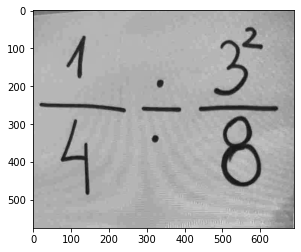

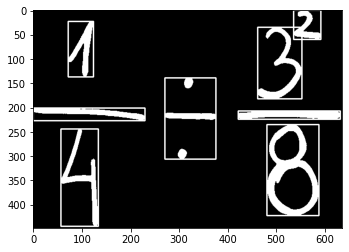

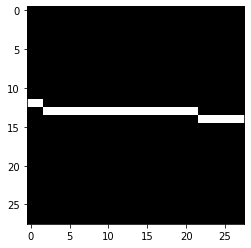

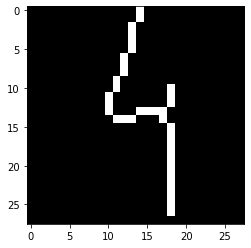

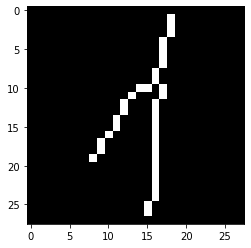

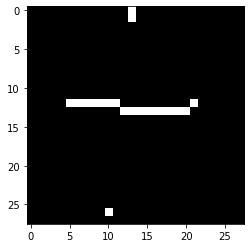

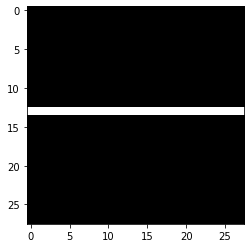

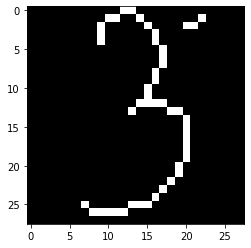

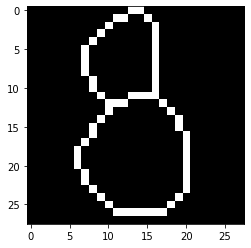

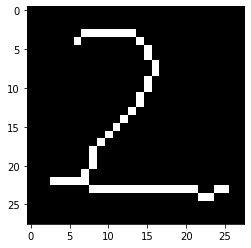

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


- ((0, 201), (230, 227))
4 ((57, 244), (134, 444))
1 ((72, 23), (124, 137))
div ((271, 139), (376, 306))
- ((422, 207), (632, 224))
3 ((462, 35), (553, 182))
8 ((481, 235), (588, 422))
2 ((536, 0), (592, 60))
\frac{1}{4}
div
\frac{32}{8}
\frac{1}{4}
div
\frac{32}{8}
3^{2}
3^{2}
nodes end found \frac{1}{4} \div \frac{3^{2}}{8}


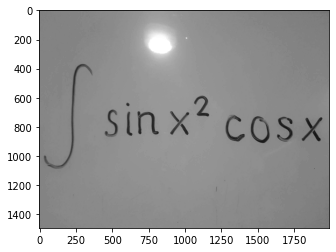

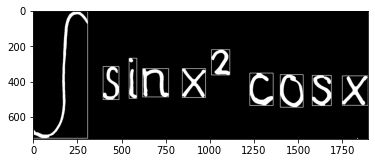

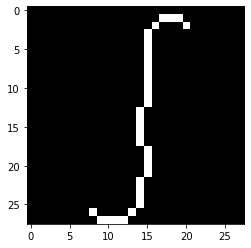

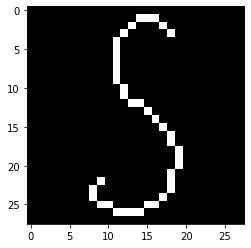

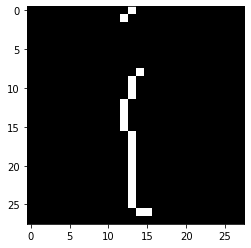

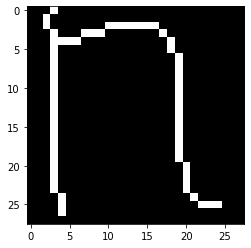

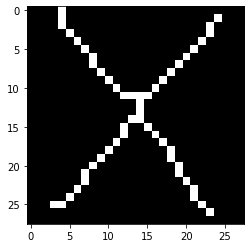

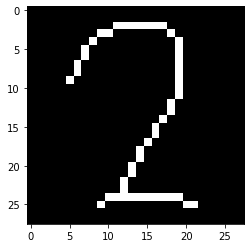

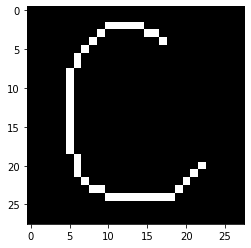

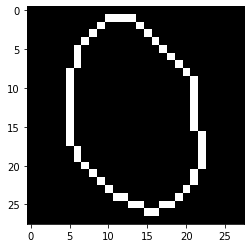

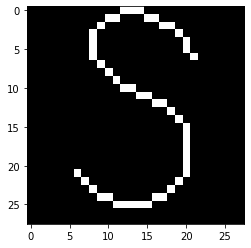

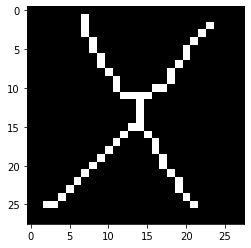

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 0), (309, 718))
s ((396, 313), (486, 500))
i ((543, 266), (587, 493))
n ((620, 325), (767, 485))
x ((844, 325), (976, 488))
2 ((1009, 218), (1113, 361))
c ((1226, 350), (1358, 533))
0 ((1398, 359), (1528, 543))
s ((1579, 363), (1687, 534))
x ((1749, 366), (1895, 532))
\int
s
i
n
x
c
0
s
x
\int
s
i
n
x^{2}
c
0
s
x
nodes end found  \int  \sin x^{2} \cos x


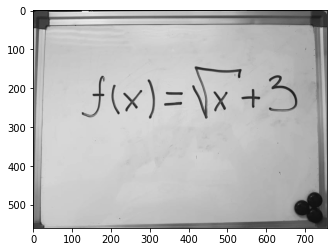

smth1


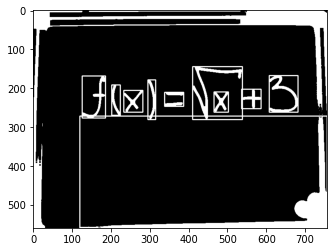

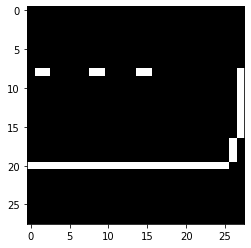

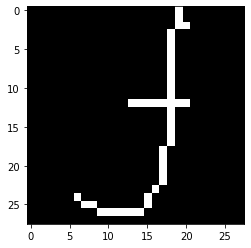

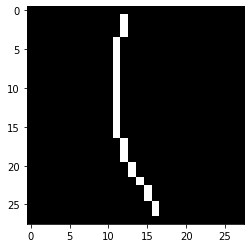

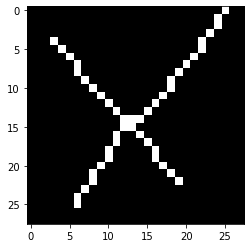

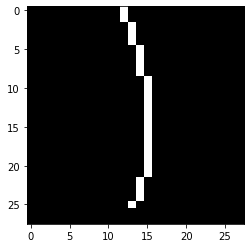

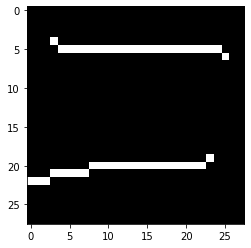

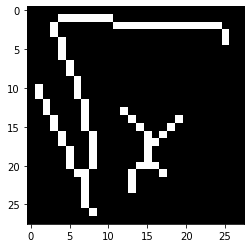

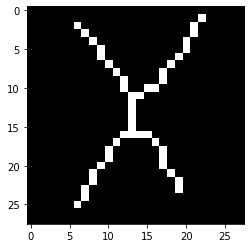

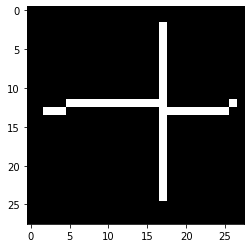

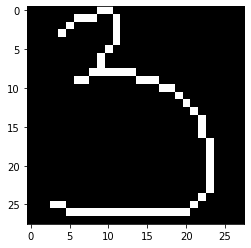

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


= ((120, 272), (756, 560))
1 ((126, 169), (186, 277))
1 ((202, 192), (224, 270))
x ((233, 206), (282, 262))
) ((295, 179), (315, 281))
= ((338, 211), (387, 247))
sqrt ((410, 145), (538, 281))
x ((465, 210), (502, 262))
+ ((536, 203), (586, 253))
3 ((607, 168), (681, 262))
=^{11x)=sqrtx+3}
=^{11x)=sqrtx+3}
1
1
x
)
=
sqrt{x}
+
3
1
1
x
)
=
sqrt{x}
+
3
nodes end found =^{f(x)=\sqrt{x}+3}


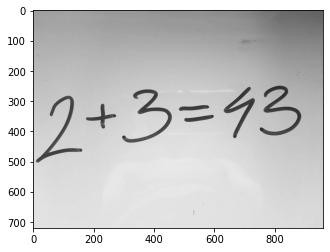

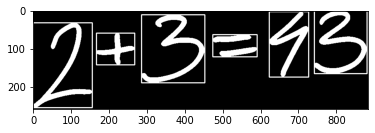

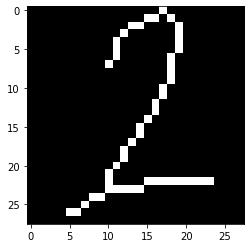

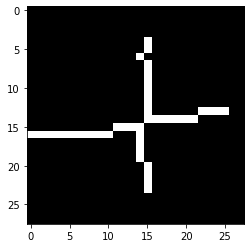

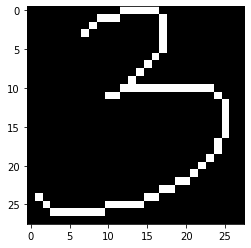

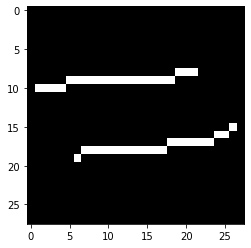

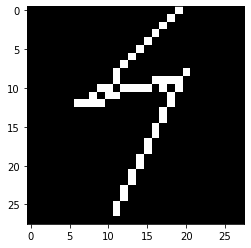

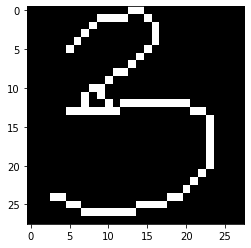

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


2 ((0, 33), (156, 255))
+ ((167, 60), (268, 143))
3 ((286, 12), (453, 190))
= ((474, 64), (591, 122))
4 ((623, 4), (727, 175))
3 ((742, 0), (881, 166))
2
+
3
=
4
3
2
+
3
=
4
3
nodes end found 2+3=43


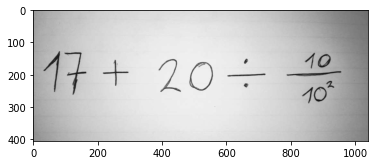

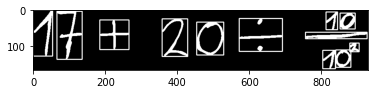

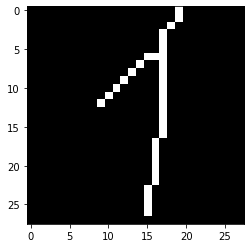

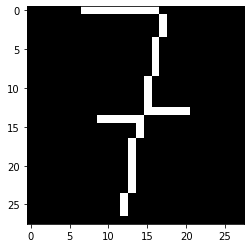

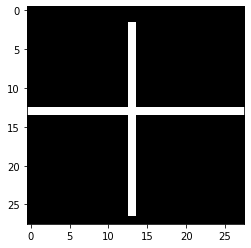

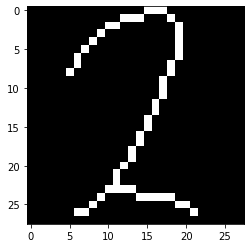

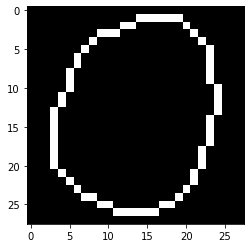

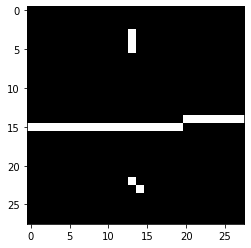

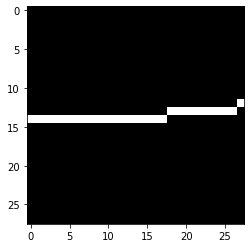

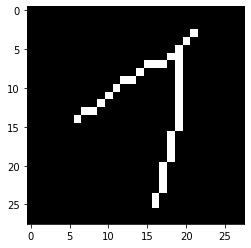

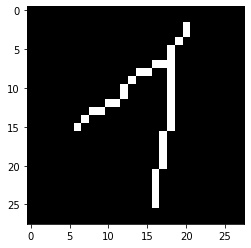

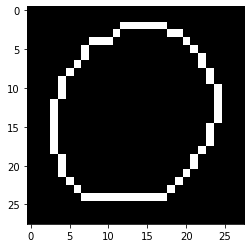

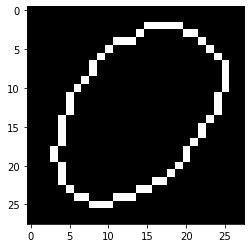

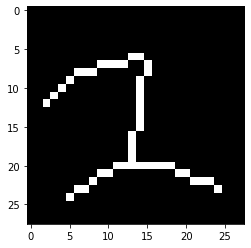

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


1 ((0, 0), (54, 127))
7 ((66, 3), (136, 136))
+ ((185, 27), (266, 109))
2 ((358, 24), (429, 128))
0 ((454, 33), (529, 124))
div ((572, 23), (692, 114))
- ((756, 61), (927, 79))
1 ((804, 111), (839, 162))
1 ((813, 5), (845, 54))
0 ((840, 110), (882, 158))
0 ((852, 8), (894, 52))
i ((879, 91), (905, 115))
1
7
+
2
0
div
\frac{10}{10i}
1
7
+
2
0
div
\frac{10}{10i}
1
0
1
0
1
0^{i}
1
0^{i}
nodes end found 17+20 \div \frac{10}{10^{i}}


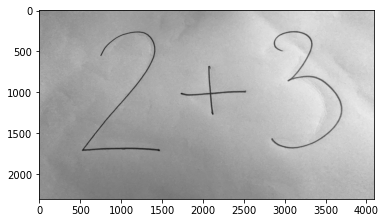

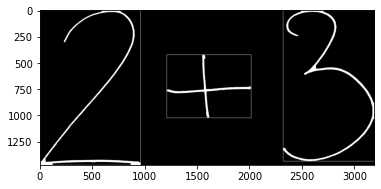

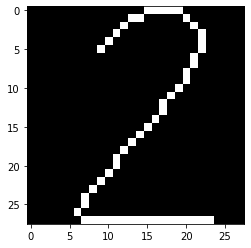

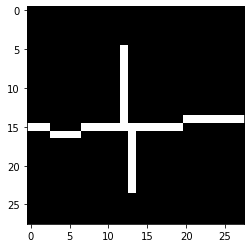

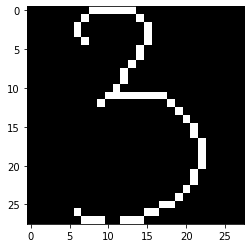

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


2 ((0, 0), (957, 1471))
+ ((1207, 424), (2011, 1023))
3 ((2315, 0), (3191, 1434))
2
+
3
2
+
3
nodes end found 2+3


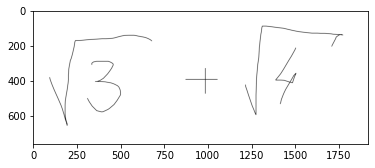

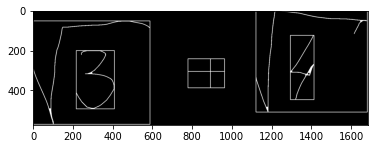

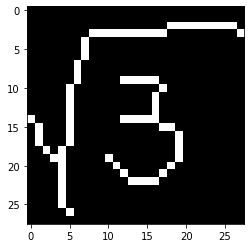

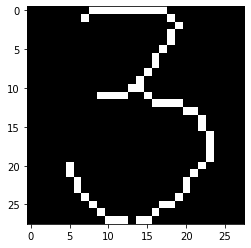

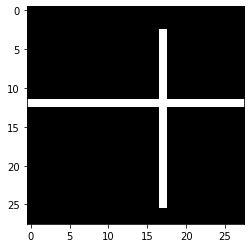

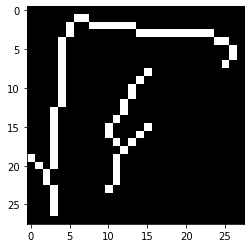

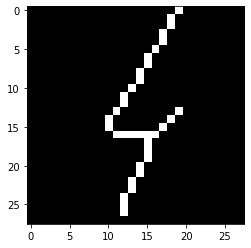

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


sqrt ((0, 54), (588, 570))
3 ((217, 202), (409, 493))
+ ((779, 243), (963, 388))
sqrt ((1121, 0), (1681, 509))
4 ((1294, 126), (1413, 447))
sqrt{3}
+
sqrt{4}
sqrt{3}
+
sqrt{4}
nodes end found \sqrt{3}+\sqrt{4}


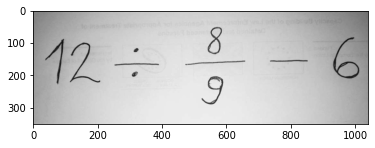

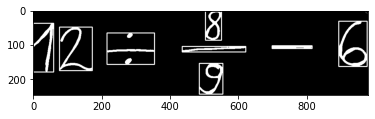

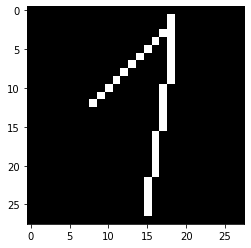

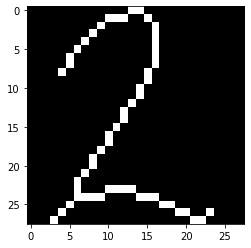

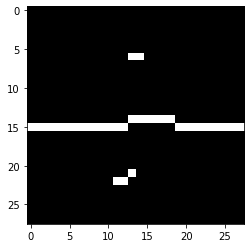

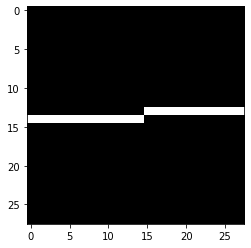

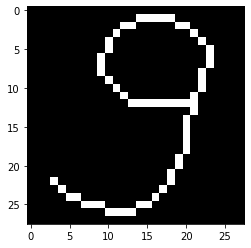

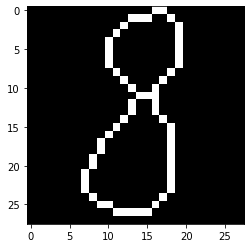

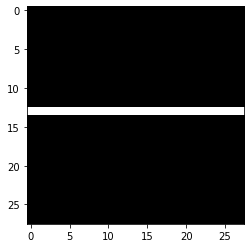

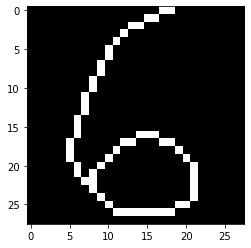

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


1 ((0, 38), (60, 179))
2 ((77, 49), (173, 175))
div ((216, 66), (355, 157))
- ((436, 105), (622, 121))
9 ((486, 154), (555, 243))
8 ((504, 0), (551, 87))
- ((699, 103), (816, 111))
6 ((894, 32), (977, 163))
1
2
div
\frac{8}{9}
-
6
1
2
div
\frac{8}{9}
-
6
nodes end found 12 \div \frac{8}{9}-6


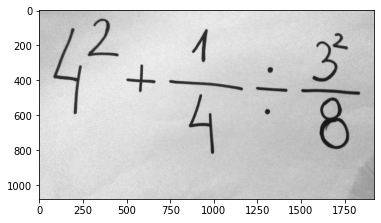

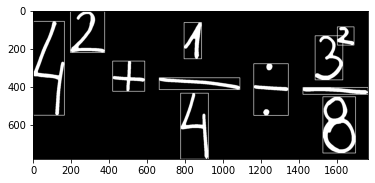

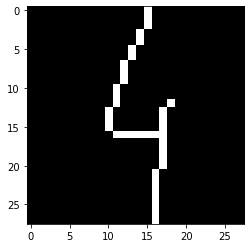

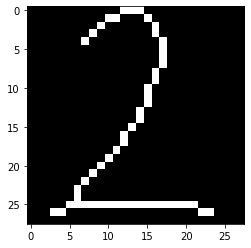

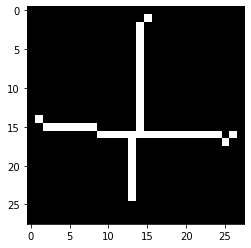

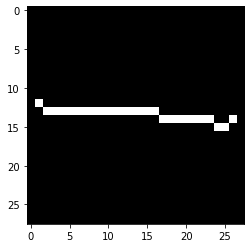

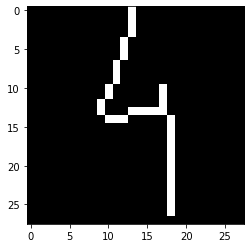

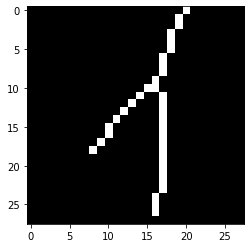

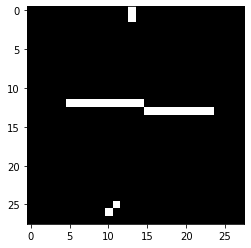

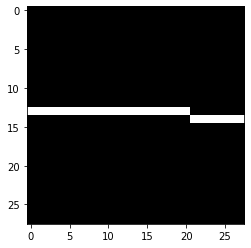

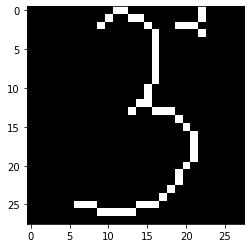

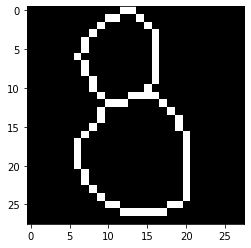

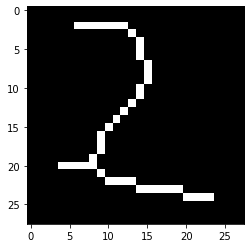

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


4 ((0, 54), (165, 548))
2 ((197, 0), (377, 218))
+ ((419, 263), (588, 422))
- ((664, 351), (1089, 413))
4 ((777, 432), (923, 779))
1 ((795, 60), (887, 251))
div ((1162, 277), (1344, 549))
- ((1421, 402), (1764, 438))
3 ((1485, 130), (1631, 362))
8 ((1526, 451), (1698, 747))
2 ((1602, 83), (1690, 179))
4
+
\frac{1}{4}
div
\frac{32}{8}
4^{2}
+
\frac{1}{4}
div
\frac{32}{8}
3^{2}
3^{2}
nodes end found 4^{2}+\frac{1}{4} \div \frac{3^{2}}{8}


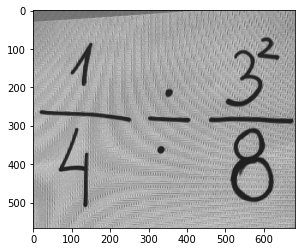

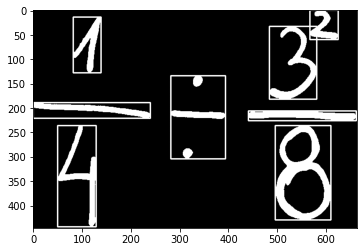

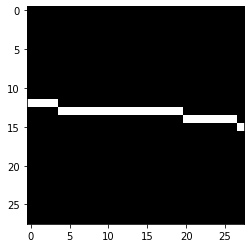

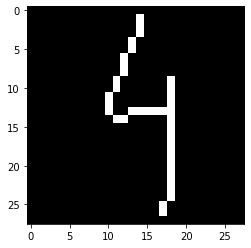

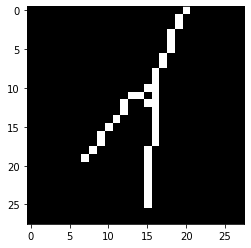

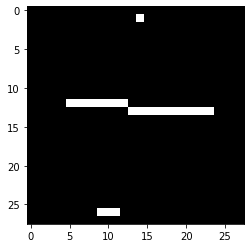

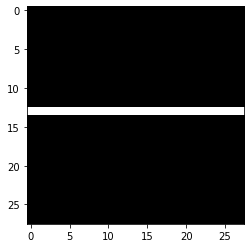

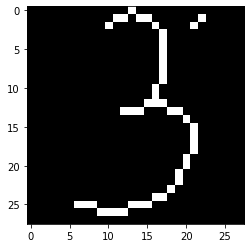

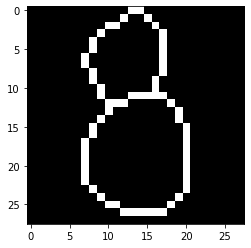

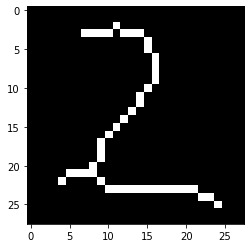

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


- ((0, 189), (240, 221))
4 ((50, 236), (129, 443))
1 ((82, 14), (139, 128))
div ((282, 134), (394, 304))
- ((441, 206), (662, 226))
3 ((484, 33), (581, 182))
8 ((496, 236), (610, 429))
2 ((567, 0), (625, 60))
\frac{1}{4}
div
\frac{32}{8}
\frac{1}{4}
div
\frac{32}{8}
3^{2}
3^{2}
nodes end found \frac{1}{4} \div \frac{3^{2}}{8}


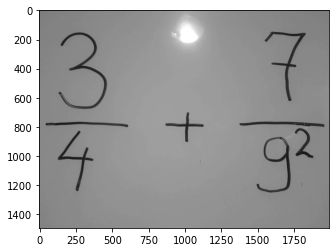

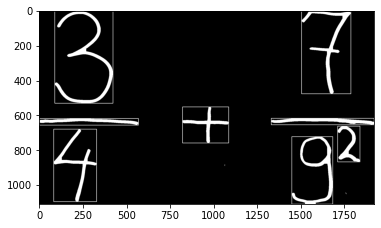

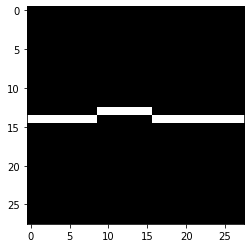

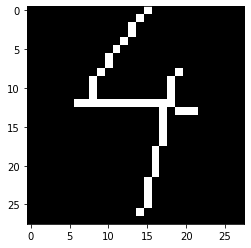

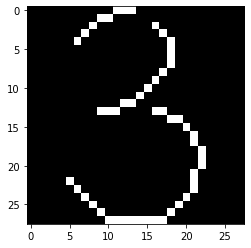

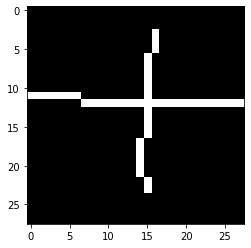

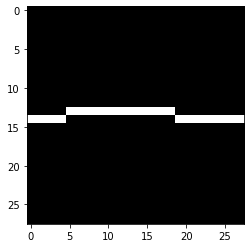

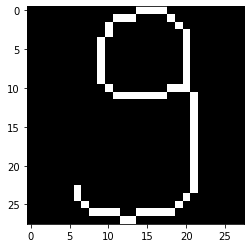

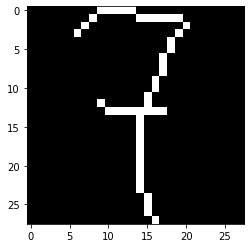

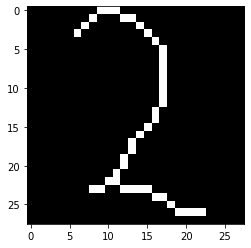

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


- ((0, 619), (570, 657))
4 ((84, 680), (330, 1094))
3 ((90, 0), (424, 532))
+ ((823, 553), (1088, 759))
- ((1332, 618), (1922, 655))
9 ((1450, 723), (1685, 1108))
7 ((1506, 0), (1789, 478))
2 ((1713, 663), (1841, 867))
\frac{3}{4}
+
\frac{7}{92}
\frac{3}{4}
+
\frac{7}{92}
9^{2}
9^{2}
nodes end found \frac{3}{4}+\frac{7}{9^{2}}


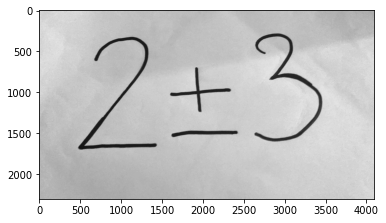

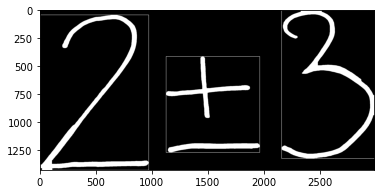

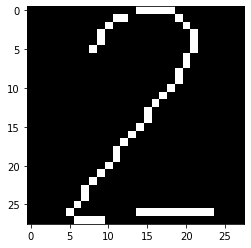

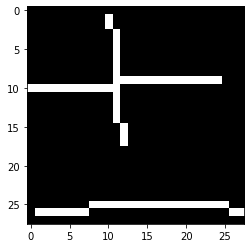

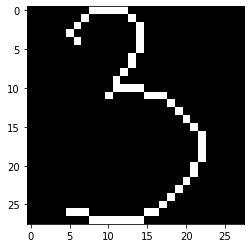

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


2 ((0, 43), (970, 1424))
pm ((1125, 413), (1961, 1267))
3 ((2156, 0), (2990, 1321))
2
pm
3
2
pm
3
nodes end found 2\pm3


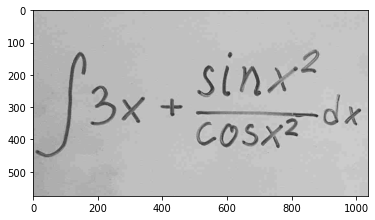

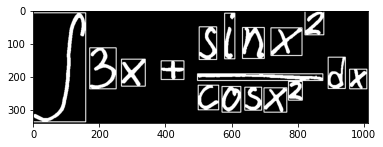

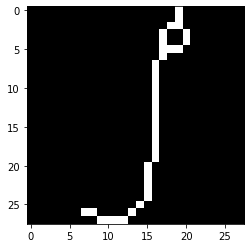

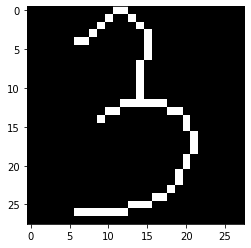

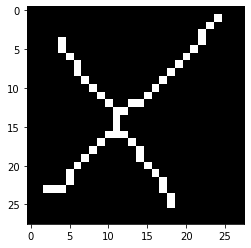

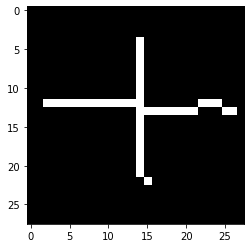

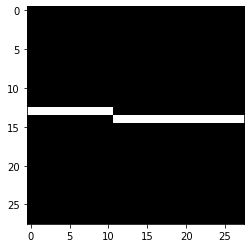

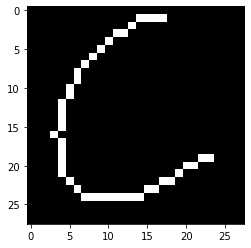

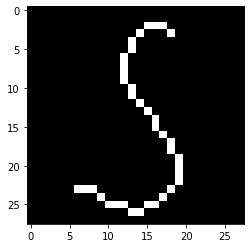

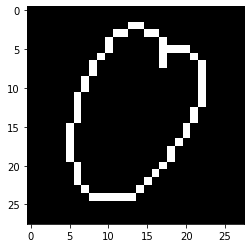

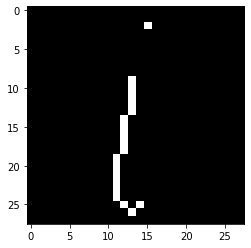

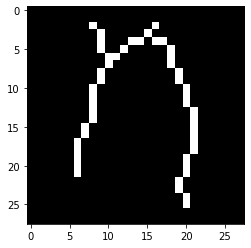

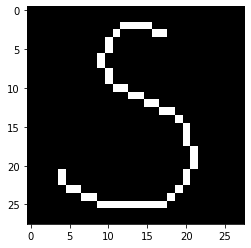

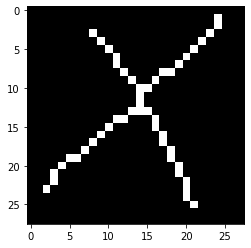

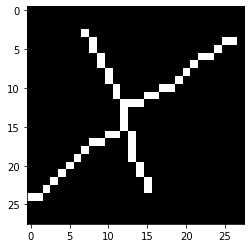

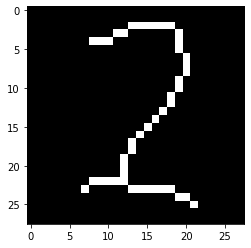

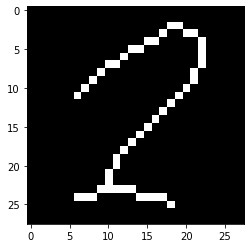

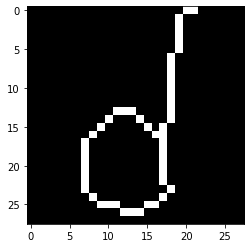

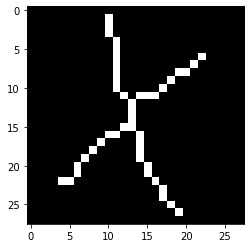

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 8), (159, 335))
3 ((171, 113), (251, 236))
x ((267, 147), (339, 228))
+ ((387, 152), (456, 208))
- ((497, 191), (876, 211))
c ((499, 225), (561, 299))
s ((502, 50), (555, 148))
0 ((571, 229), (628, 306))
i ((579, 9), (610, 146))
n ((633, 52), (699, 145))
s ((640, 231), (691, 300))
x ((698, 233), (767, 306))
x ((719, 53), (813, 136))
2 ((772, 214), (814, 270))
2 ((822, 0), (879, 74))
d ((892, 141), (944, 235))
x ((957, 177), (1009, 236))
\int
3
x
+
\frac{sinx2}{c0sx2}
d
x
\int
3
x
+
\frac{sinx2}{c0sx2}
d
x
s
i
n
x^{2}
s
i
n
x^{2}
c
0
s
x^{2}
c
0
s
x^{2}
nodes end found  \int 3x+\frac{ \sin x^{2}}{ \cos x^{2}} dx 


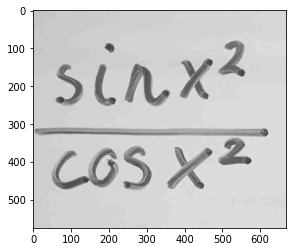

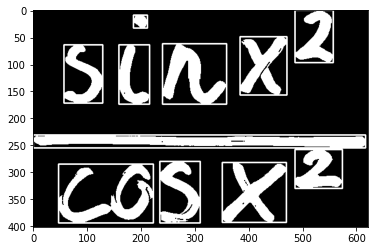

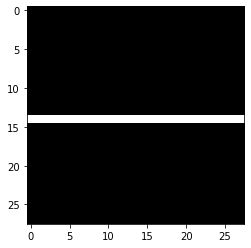

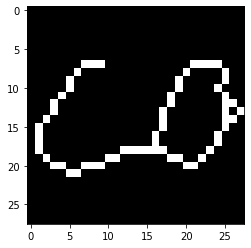

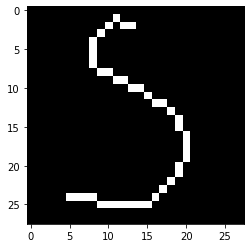

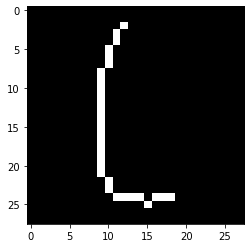

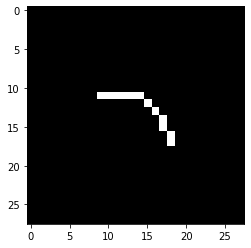

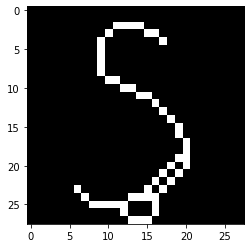

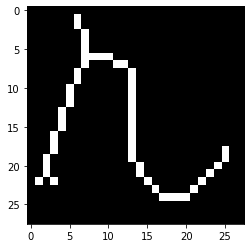

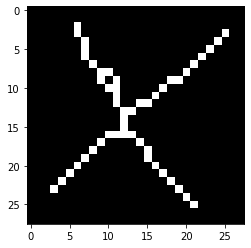

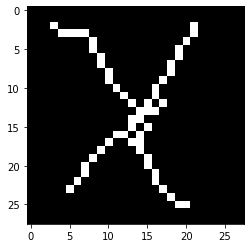

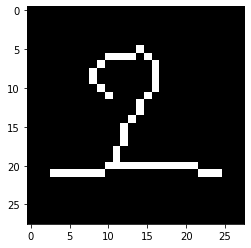

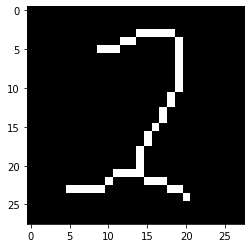

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


- ((0, 231), (617, 255))
a ((47, 285), (223, 394))
9 ((57, 64), (129, 172))
( ((159, 64), (216, 174))
7 ((186, 9), (212, 33))
s ((235, 280), (310, 394))
n ((240, 62), (359, 174))
x ((351, 282), (470, 393))
x ((384, 49), (471, 157))
2 ((486, 258), (574, 330))
2 ((486, 0), (557, 97))
\frac{9(7nx2}{asx2}
\frac{9(7nx2}{asx2}
9
(^{7}
n
x^{2}
9
(^{7}
n
x^{2}
a
s
x^{2}
a
s
x^{2}
nodes end found \frac{91^{7}nx^{2}}{asx^{2}}


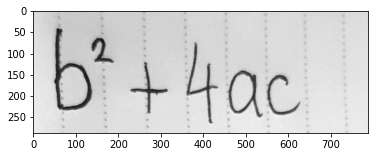

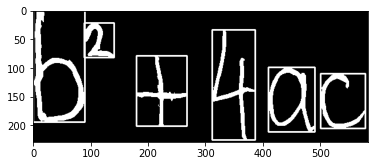

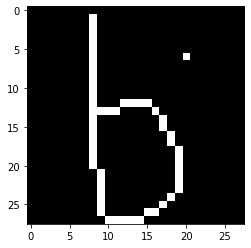

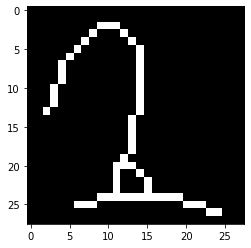

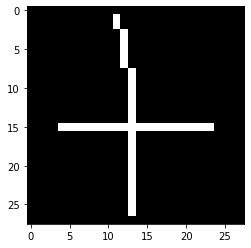

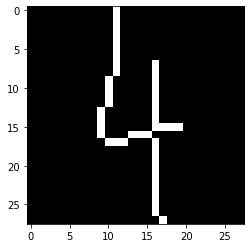

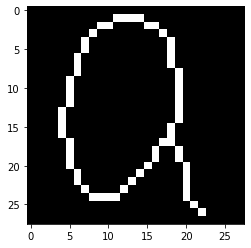

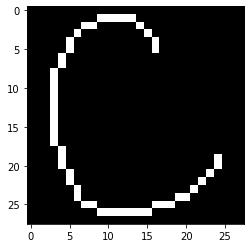

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 0), (90, 194))
2 ((89, 22), (141, 82))
+ ((180, 79), (268, 201))
4 ((312, 34), (387, 225))
a ((410, 99), (491, 211))
c ((501, 110), (579, 205))
\int
2_{c}
\int
2_{c}
nodes end found  \int 2_{c}


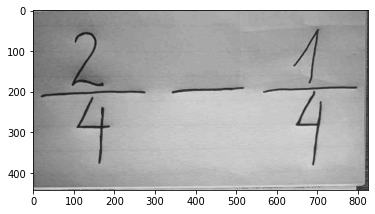

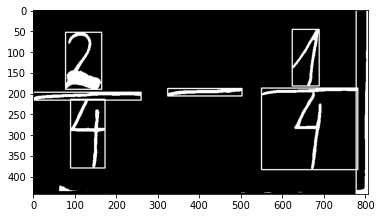

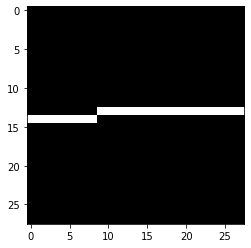

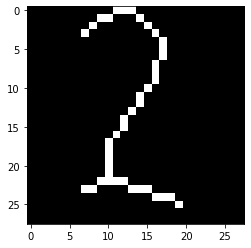

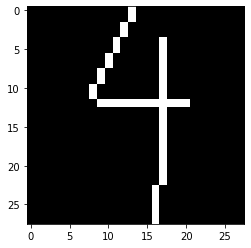

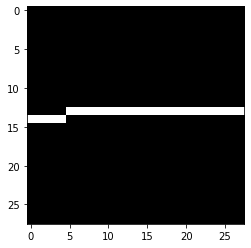

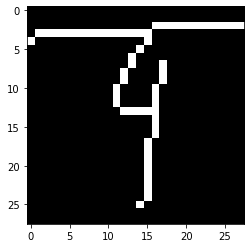

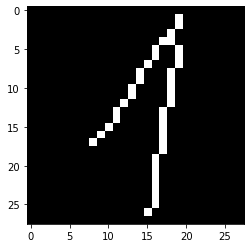

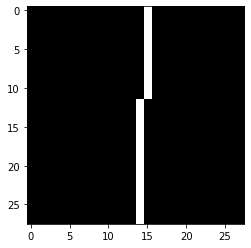

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


- ((0, 197), (260, 216))
2 ((78, 53), (165, 190))
4 ((90, 214), (173, 379))
- ((324, 188), (503, 206))
9 ((550, 187), (782, 383))
1 ((624, 46), (689, 182))
1 ((778, 0), (807, 442))
\frac{2}{4}
-
9^{1}
1
\frac{2}{4}
-
9^{1}
1
nodes end found \frac{2}{4}-9^{1}1


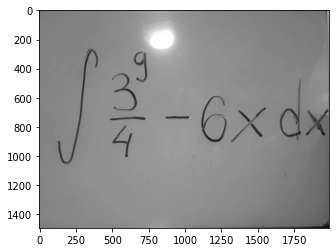

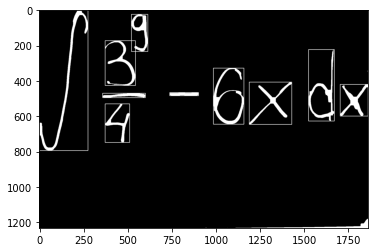

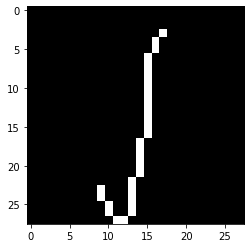

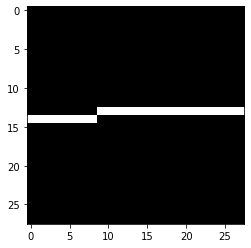

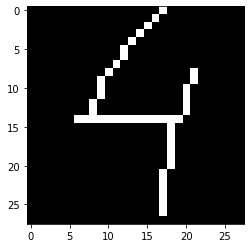

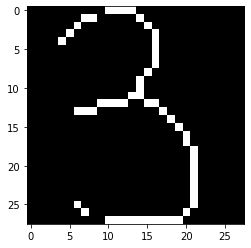

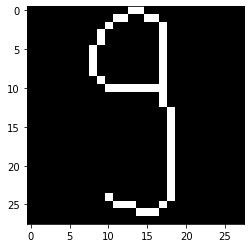

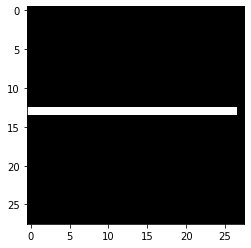

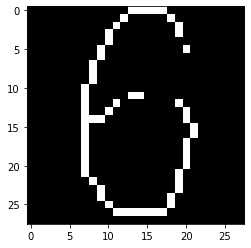

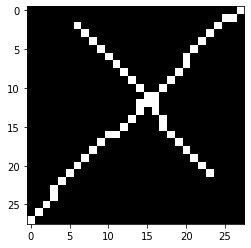

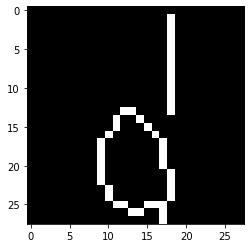

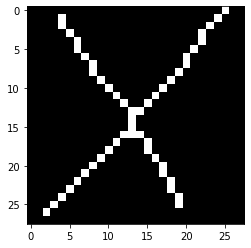

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 0), (277, 794))
- ((360, 470), (602, 495))
4 ((374, 530), (513, 748))
3 ((374, 173), (546, 426))
9 ((523, 24), (616, 234))
- ((740, 466), (903, 484))
6 ((987, 328), (1160, 645))
x ((1190, 407), (1431, 646))
d ((1526, 223), (1672, 627))
x ((1705, 420), (1863, 599))
\int
\frac{39}{4}
-
6
x
x
d
\int
\frac{39}{4}
-
6
x
x
d
3^{9}
3^{9}
nodes end found  \int \frac{3^{9}}{4}-6xxd


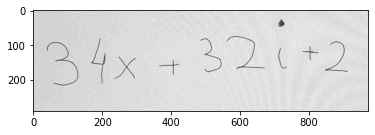

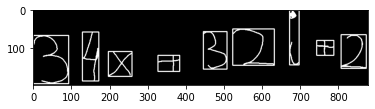

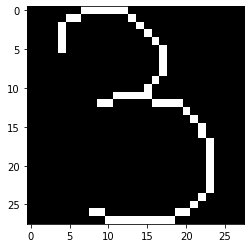

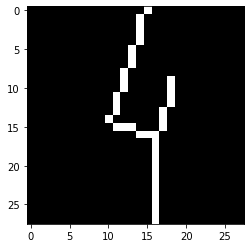

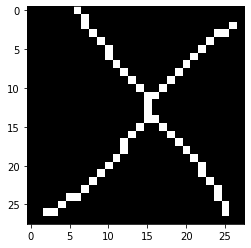

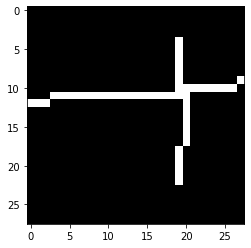

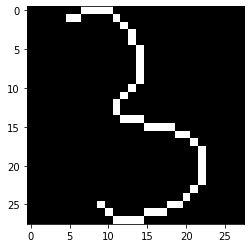

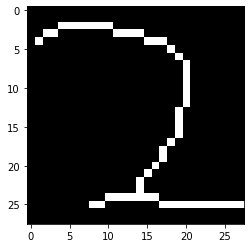

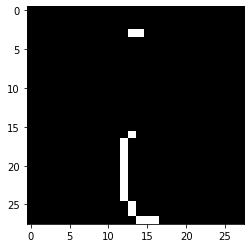

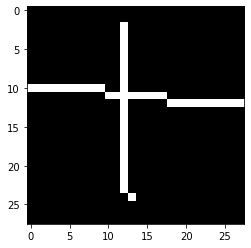

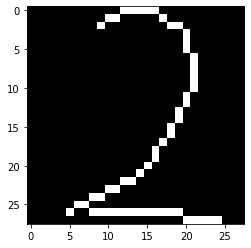

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


3 ((0, 66), (93, 192))
4 ((129, 57), (172, 185))
x ((197, 108), (259, 173))
+ ((327, 118), (384, 160))
3 ((446, 56), (508, 154))
2 ((523, 49), (632, 144))
i ((672, 0), (697, 143))
+ ((743, 79), (788, 118))
2 ((807, 64), (873, 152))
3
4
x
+
3
2
i
+
2
3
4
x
+
3
2
i
+
2
nodes end found 34x+32i+2


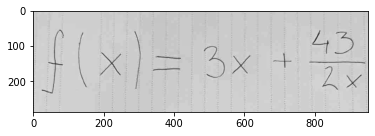

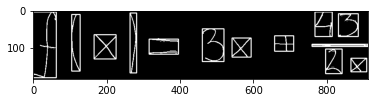

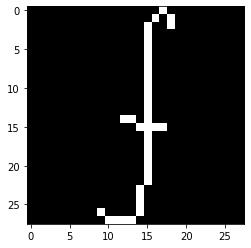

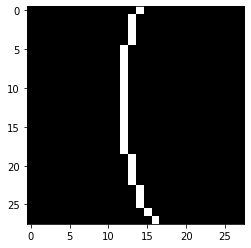

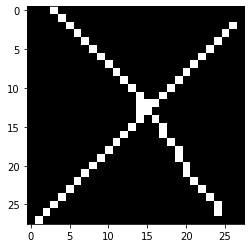

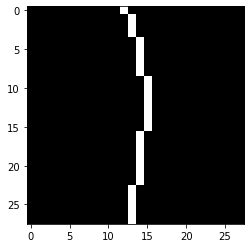

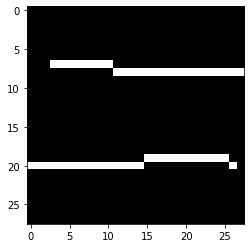

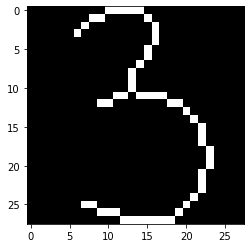

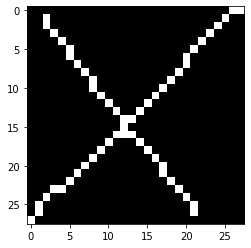

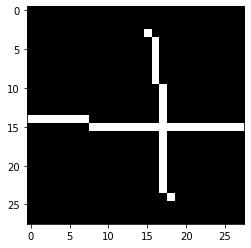

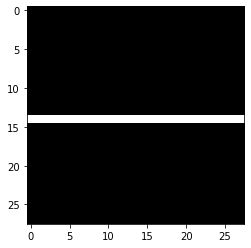

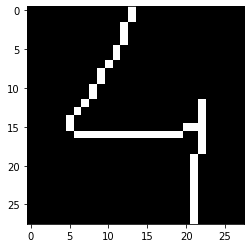

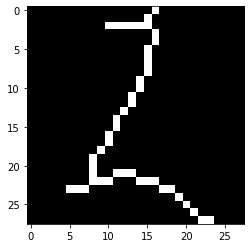

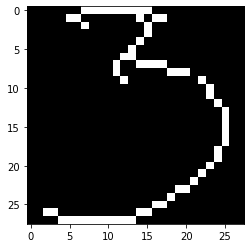

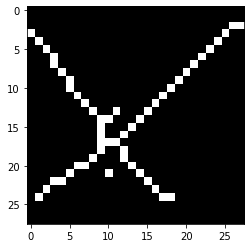

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


f ((0, 2), (63, 181))
1 ((105, 9), (128, 163))
x ((166, 64), (226, 130))
) ((264, 5), (282, 168))
= ((316, 76), (396, 117))
3 ((461, 48), (520, 137))
x ((542, 73), (594, 125))
+ ((658, 67), (710, 109))
- ((760, 90), (913, 96))
4 ((768, 2), (815, 69))
2 ((797, 103), (842, 170))
3 ((832, 7), (886, 69))
x ((866, 128), (909, 165))
f
1
x
)
=
3
x
\frac{43}{2x}
f
1
x
)
=
3
x
\frac{43}{2x}
4
3
4
3
2
x
2
x
nodes end found f(x)=3x\frac{43}{2x}


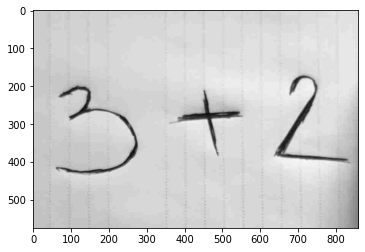

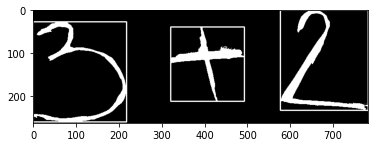

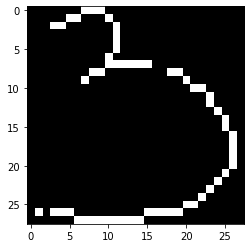

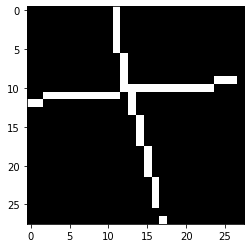

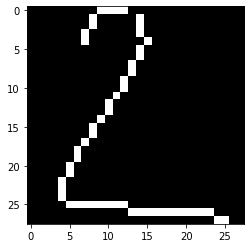

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


3 ((0, 27), (218, 260))
+ ((321, 39), (493, 212))
2 ((577, 0), (782, 233))
3
+
2
3
+
2
nodes end found 3+2


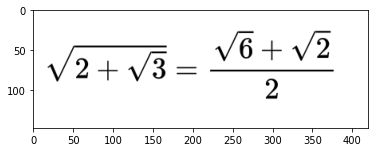

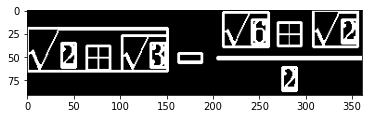

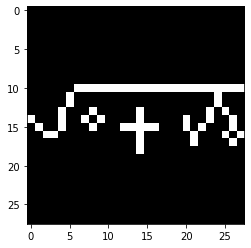

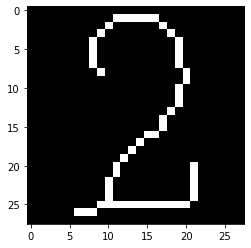

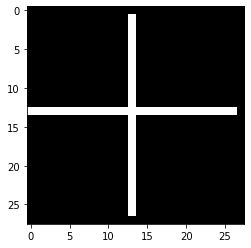

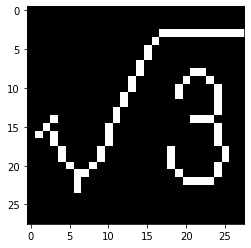

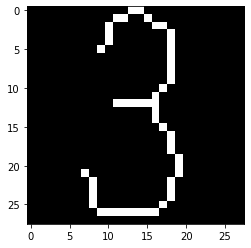

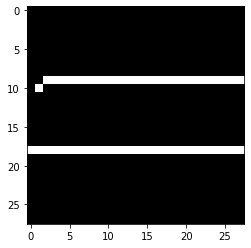

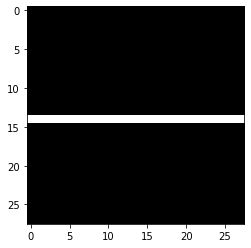

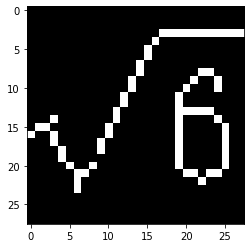

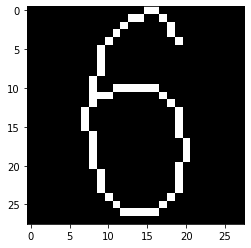

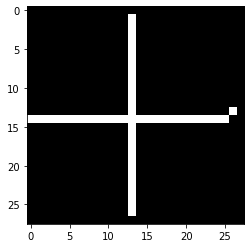

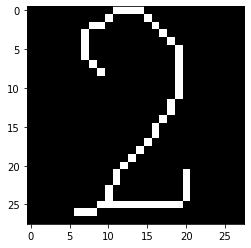

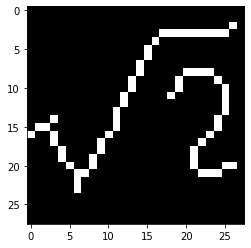

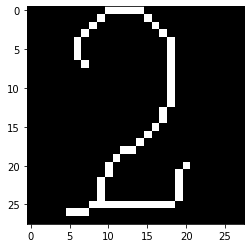

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


sqrt ((0, 19), (151, 65))
2 ((37, 35), (52, 61))
+ ((64, 38), (89, 64))
sqrt ((102, 27), (151, 65))
3 ((133, 35), (149, 61))
= ((163, 46), (188, 56))
- ((205, 50), (360, 52))
sqrt ((211, 2), (260, 39))
6 ((242, 10), (258, 36))
+ ((270, 13), (295, 38))
2 ((275, 61), (290, 86))
sqrt ((308, 0), (356, 39))
2 ((339, 10), (355, 35))
sqrt{2+sqrt3}
=
\frac{sqrt6+sqrt2}{2}
sqrt{2+sqrt3}
=
\frac{sqrt6+sqrt2}{2}
2
+
sqrt{3}
2
+
sqrt{3}
sqrt{6}
+
sqrt{2}
sqrt{6}
+
sqrt{2}
nodes end found \sqrt{2+\sqrt{3}}=\frac{\sqrt{6}+\sqrt{2}}{2}


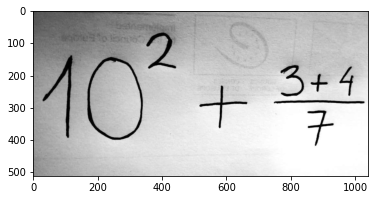

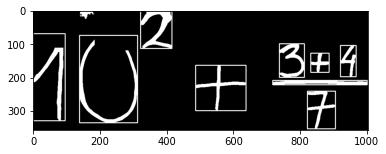

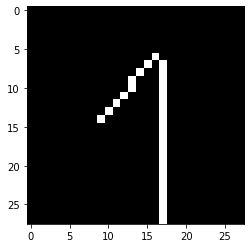

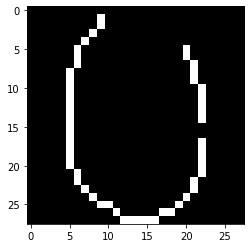

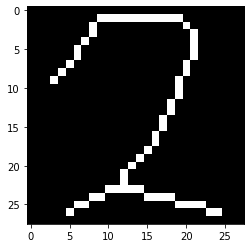

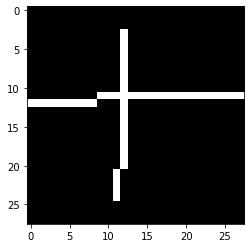

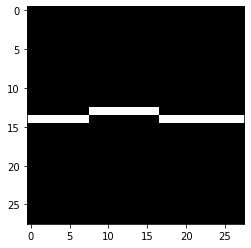

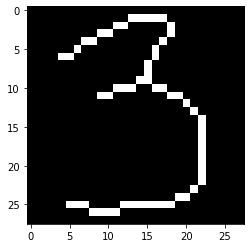

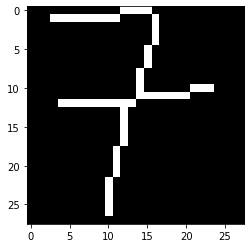

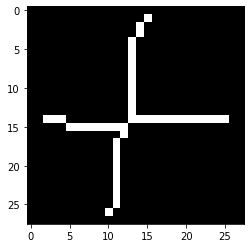

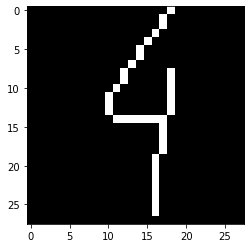

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


1 ((0, 70), (96, 329))
0 ((139, 75), (313, 335))
2 ((322, 0), (416, 114))
+ ((487, 164), (638, 299))
- ((718, 209), (1001, 222))
3 ((738, 100), (813, 200))
7 ((822, 241), (906, 353))
+ ((832, 128), (887, 185))
4 ((921, 105), (968, 198))
1
0
+
\frac{3+4}{7}
1
0^{2}
+
\frac{3+4}{7}
3
+
4
3
+
4
nodes end found 10^{2}+\frac{3+4}{7}


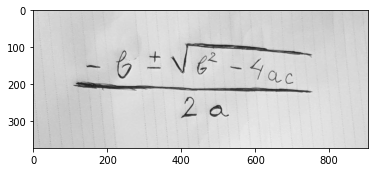

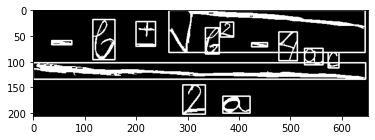

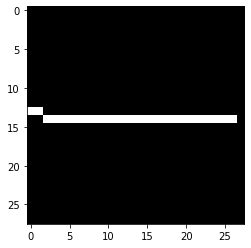

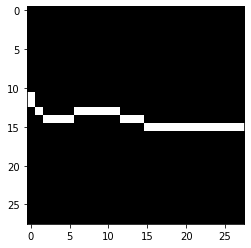

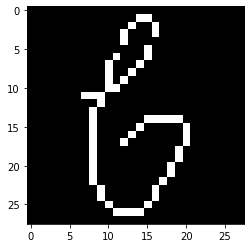

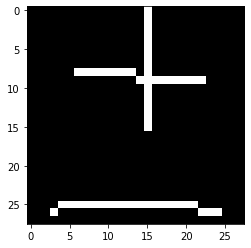

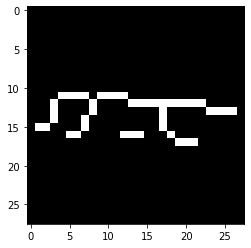

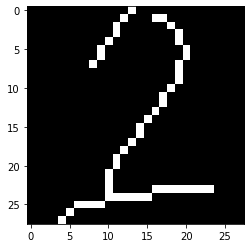

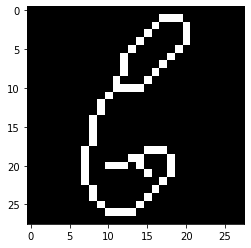

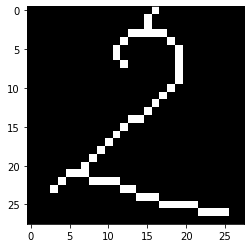

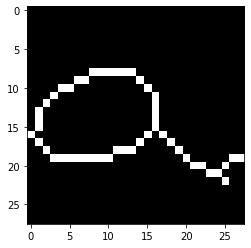

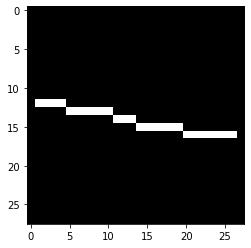

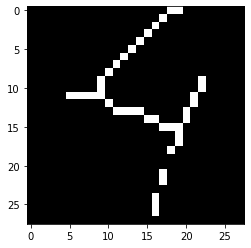

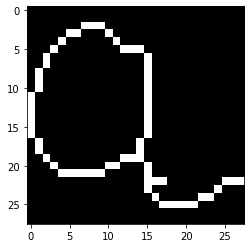

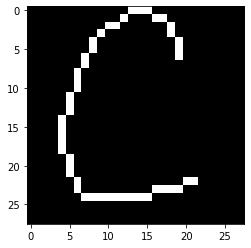

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


- ((0, 102), (647, 134))
- ((36, 59), (75, 67))
b ((116, 18), (159, 96))
pm ((200, 22), (238, 70))
sqrt ((264, 0), (646, 82))
2 ((291, 145), (335, 202))
6 ((335, 34), (362, 85))
2 ((364, 23), (390, 52))
a ((369, 167), (422, 200))
- ((425, 63), (456, 71))
4 ((478, 42), (514, 98))
a ((528, 74), (564, 106))
c ((574, 82), (595, 112))
\frac{-bpmsqrt62-4ac}{2a}
\frac{-bpmsqrt62-4ac}{2a}
-
b
pm
sqrt{62}
-
b
pm
sqrt{62}
-
4_{c}
-
4_{c}
6^{2}
6^{2}
2
a
2
a
nodes end found \frac{-b\pm\sqrt{6^{2}}}{2a}


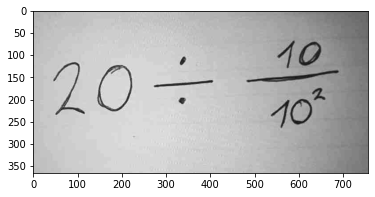

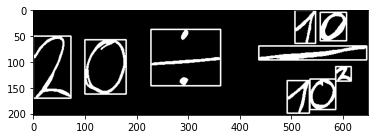

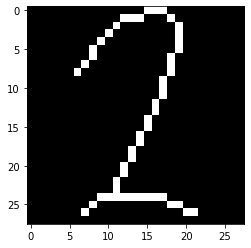

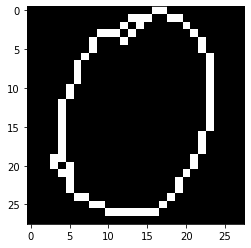

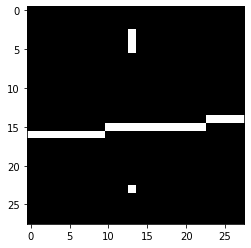

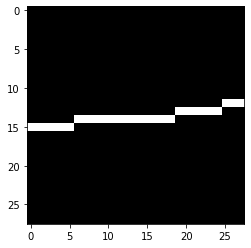

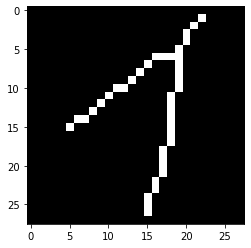

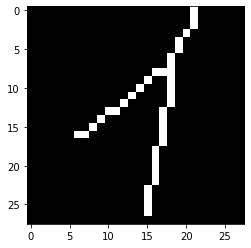

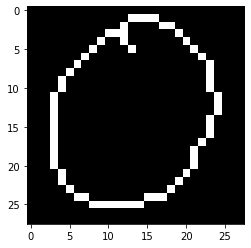

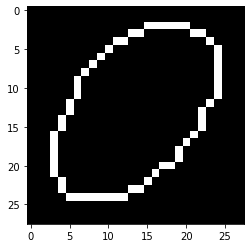

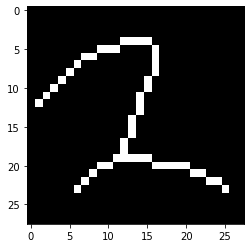

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


2 ((0, 50), (73, 170))
0 ((100, 57), (180, 162))
div ((228, 37), (363, 146))
- ((437, 69), (646, 96))
1 ((492, 136), (535, 199))
1 ((507, 0), (547, 64))
0 ((536, 133), (586, 192))
0 ((556, 4), (607, 59))
2 ((586, 109), (616, 137))
2
0
div
\frac{10}{102}
2
0
div
\frac{10}{102}
1
0
1
0
1
0^{2}
1
0^{2}
nodes end found 20 \div \frac{10}{10^{2}}


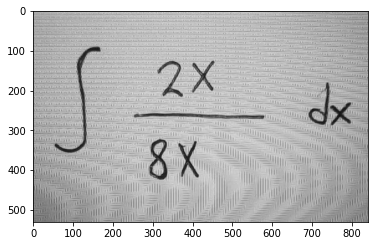

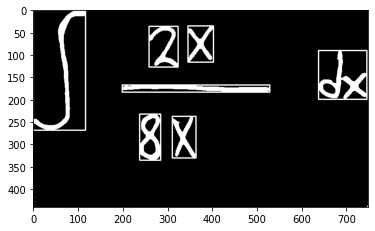

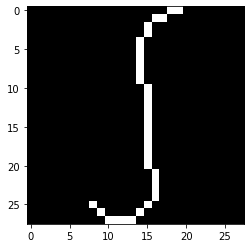

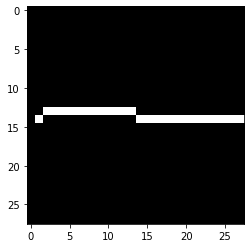

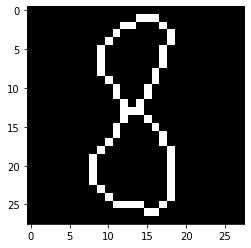

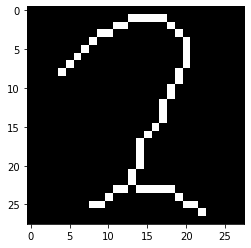

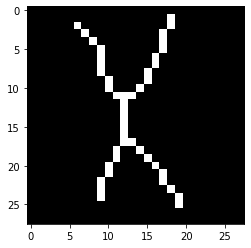

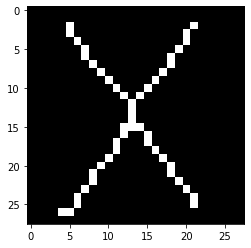

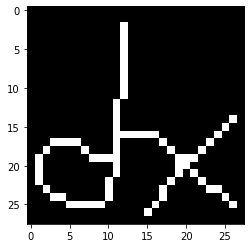

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 0), (117, 268))
- ((199, 167), (529, 183))
8 ((238, 232), (285, 335))
2 ((259, 36), (324, 127))
x ((311, 237), (364, 330))
x ((346, 35), (403, 116))
2 ((638, 90), (746, 199))
\int
\frac{2x}{8x}
2
\int
\frac{2x}{8x}
2
2
x
2
x
8
x
8
x
nodes end found  \int \frac{2x}{8x}2


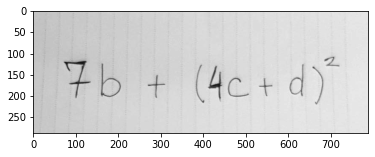

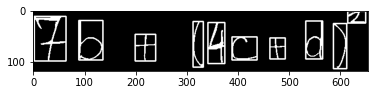

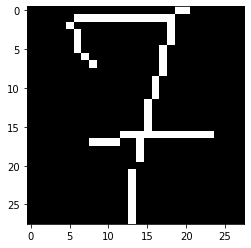

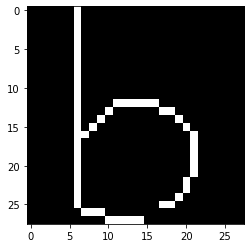

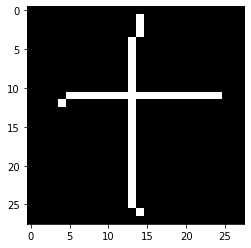

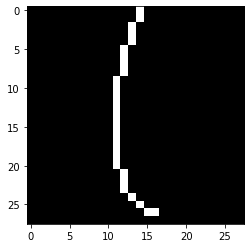

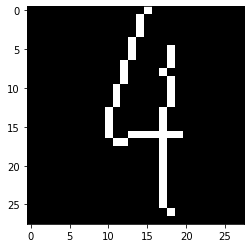

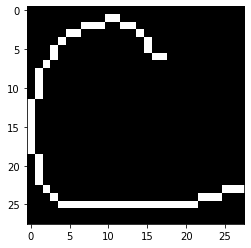

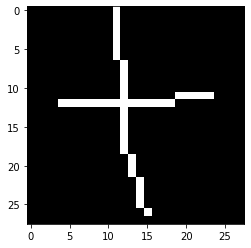

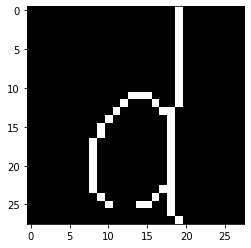

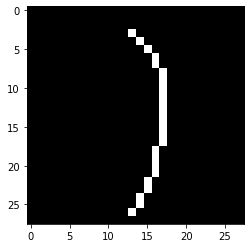

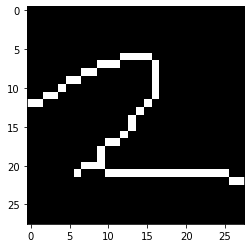

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


7 ((2, 10), (64, 97))
b ((89, 18), (136, 95))
+ ((199, 45), (239, 97))
( ((312, 20), (332, 109))
4 ((341, 22), (374, 102))
c ((388, 50), (437, 95))
+ ((462, 52), (492, 93))
d ((532, 19), (565, 93))
) ((586, 24), (612, 112))
2 ((614, 0), (649, 23))
7
b
+
(
4
c
+
d
)^{2}
7
b
+
(
4
c
+
d
)^{2}
nodes end found 7b+(4c+d)^{2}


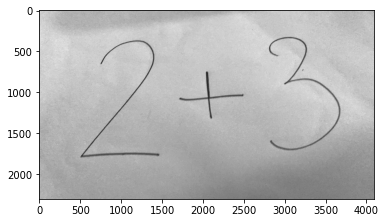

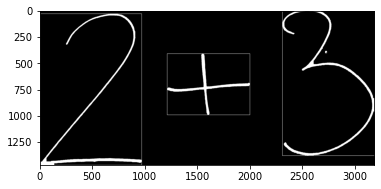

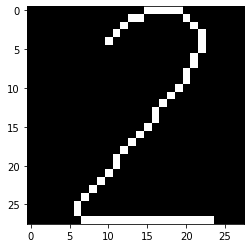

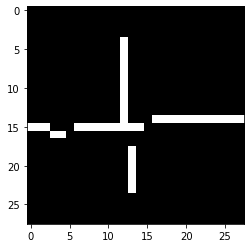

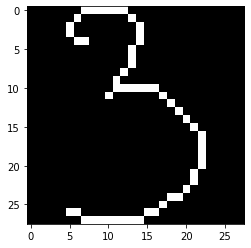

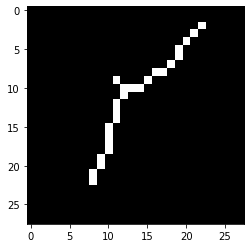

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


2 ((0, 35), (968, 1467))
+ ((1210, 413), (1998, 992))
sqrt ((2307, 0), (3189, 1378))
x ((2715, 388), (2730, 407))
2
+
sqrt{x}
2
+
sqrt{x}
nodes end found 2+\sqrt{x}


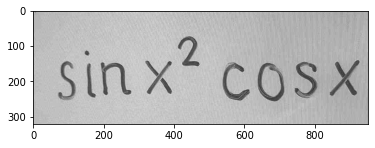

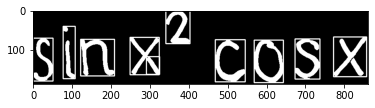

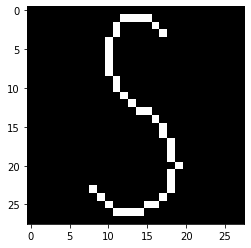

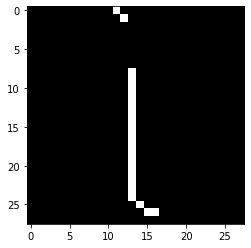

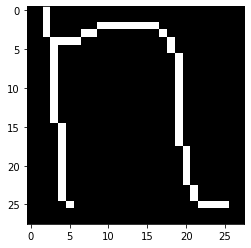

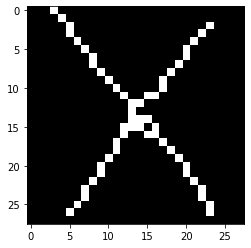

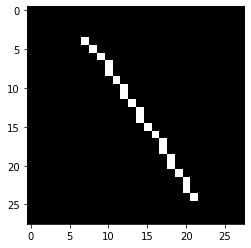

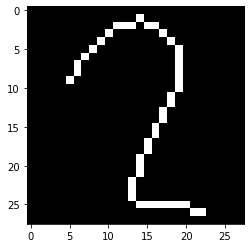

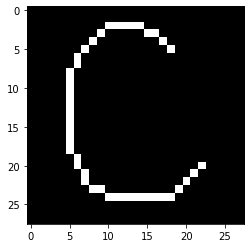

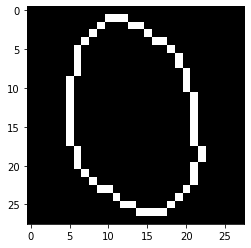

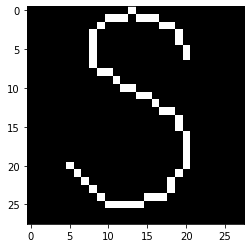

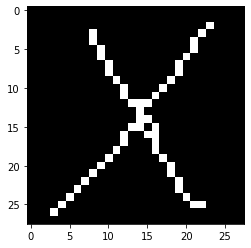

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


s ((0, 71), (51, 180))
i ((77, 41), (108, 174))
n ((122, 74), (209, 167))
sqrt ((249, 69), (324, 164))
1 ((291, 118), (325, 163))
2 ((341, 0), (403, 85))
c ((468, 75), (545, 182))
0 ((568, 76), (643, 184))
s ((673, 73), (737, 175))
x ((772, 68), (857, 169))
s
i
n
sqrt
c
0
s
x
s
i
n
sqrt
c
0
s
x
nodes end found  \sin \sqrt \cos x


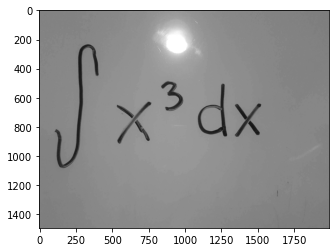

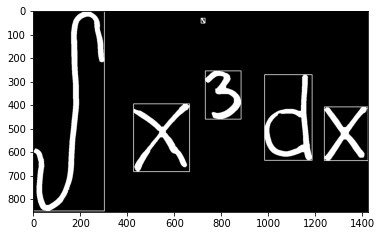

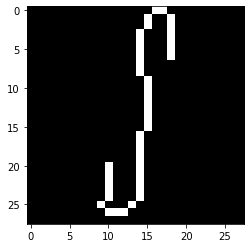

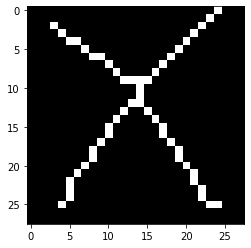

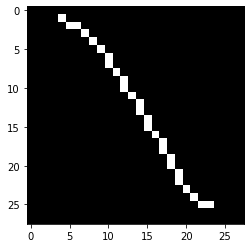

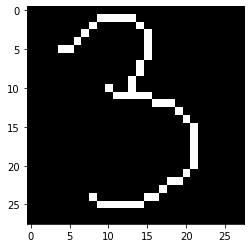

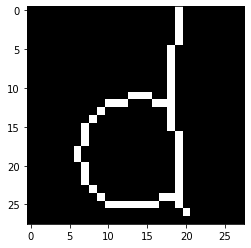

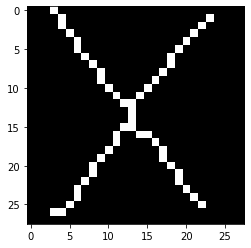

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 0), (303, 849))
x ((427, 394), (665, 682))
1 ((714, 30), (731, 51))
3 ((732, 254), (884, 459))
d ((984, 270), (1186, 634))
x ((1238, 407), (1424, 635))
\int
x
d
x
\int
x^{13}
d
x
1_{3}
1_{3}
nodes end found  \int x^{1_{3}} dx 


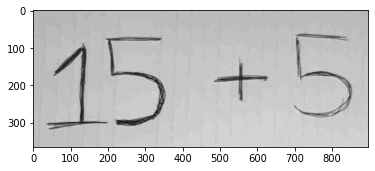

smth2


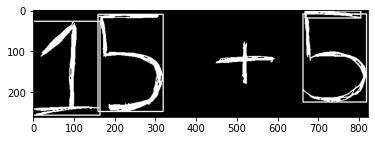

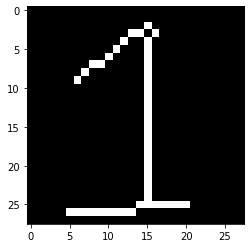

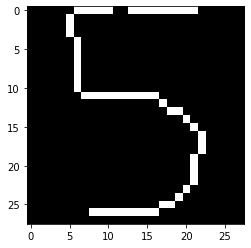

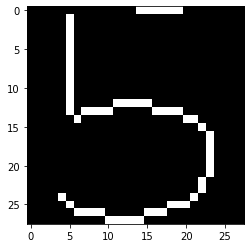

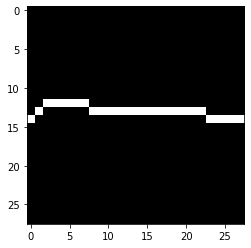

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


1 ((0, 27), (164, 256))
5 ((159, 10), (319, 247))
5 ((662, 9), (818, 224))
- ((667, 2), (804, 19))
1
5
-_{5}
1
5
-_{5}
nodes end found 15-_{5}


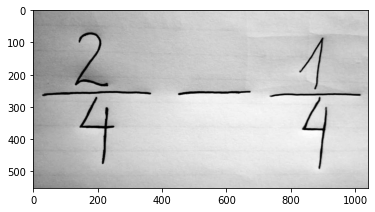

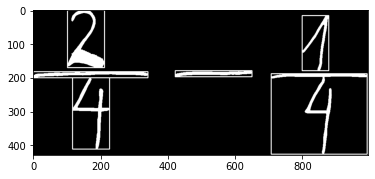

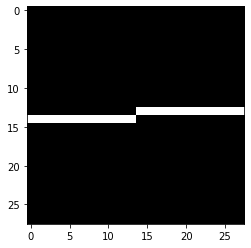

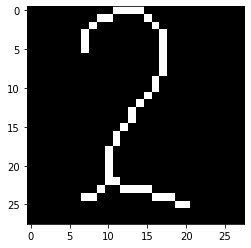

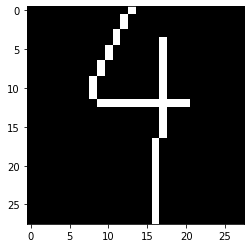

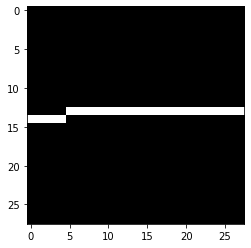

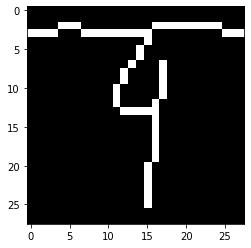

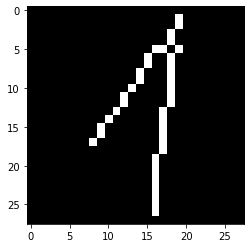

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


- ((0, 182), (341, 200))
2 ((102, 0), (212, 170))
4 ((117, 200), (227, 411))
- ((422, 179), (650, 197))
3 ((707, 188), (992, 426))
1 ((799, 16), (878, 179))
\frac{2}{4}
-
3^{1}
\frac{2}{4}
-
3^{1}
nodes end found \frac{2}{4}-3^{1}


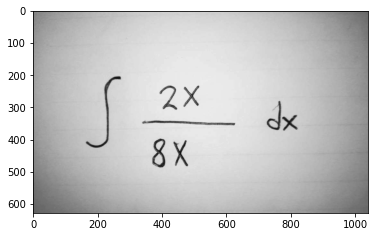

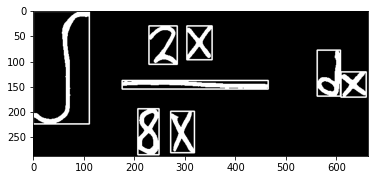

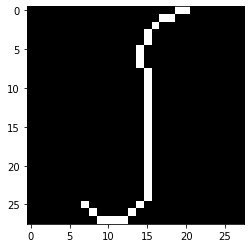

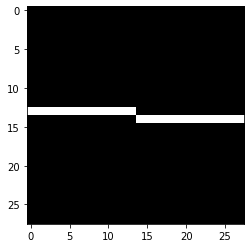

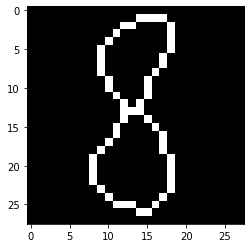

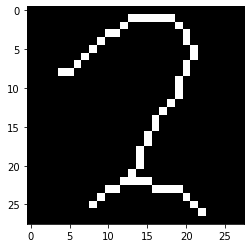

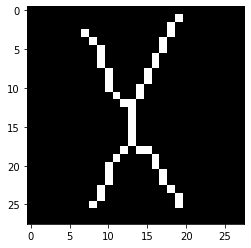

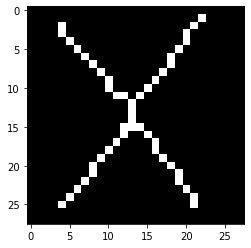

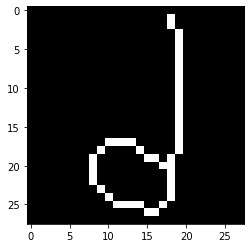

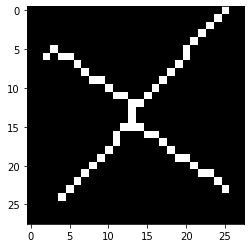

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 0), (111, 223))
- ((176, 137), (465, 154))
8 ((207, 193), (249, 284))
2 ((229, 29), (285, 105))
x ((272, 198), (319, 280))
x ((304, 29), (354, 96))
d ((562, 77), (608, 168))
x ((609, 120), (659, 170))
\int
\frac{2x}{8x}
d
x
\int
\frac{2x}{8x}
d
x
2
x
2
x
8
x
8
x
nodes end found  \int \frac{2x}{8x} dx 


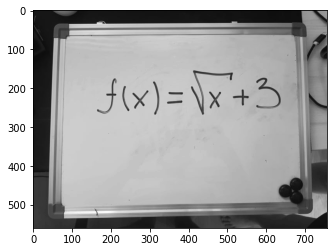

smth3
smth3


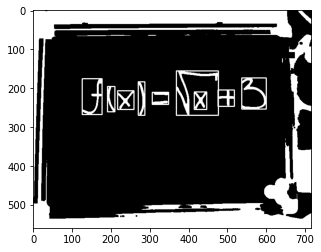

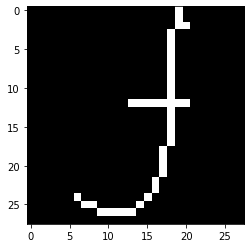

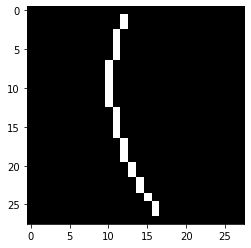

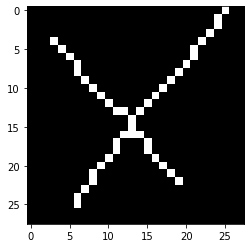

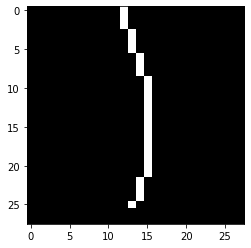

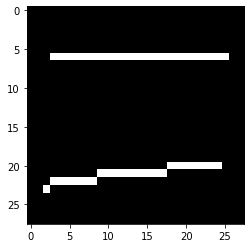

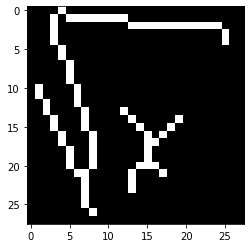

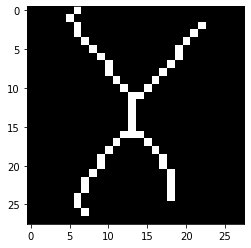

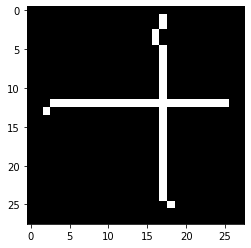

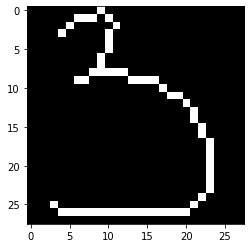

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


1 ((126, 176), (177, 268))
( ((191, 196), (210, 261))
x ((217, 207), (259, 255))
) ((270, 184), (287, 270))
= ((306, 211), (348, 242))
sqrt ((368, 156), (476, 270))
x ((414, 210), (446, 255))
+ ((475, 205), (517, 247))
3 ((536, 174), (599, 254))
1
(
x
)
=
sqrt{x}
+
3
1
(
x
)
=
sqrt{x}
+
3
nodes end found f(x)=\sqrt{x}+3


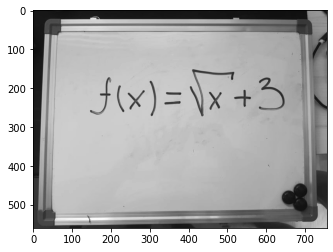

smth1
smth1


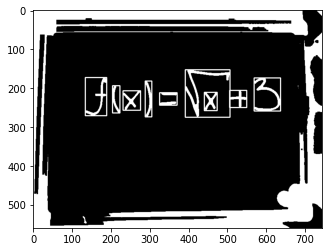

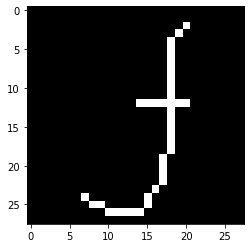

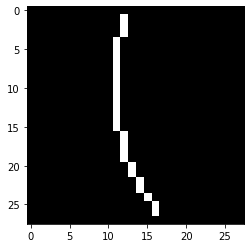

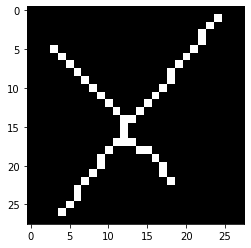

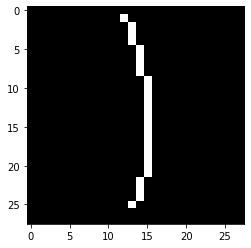

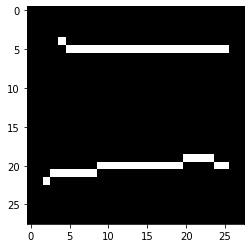

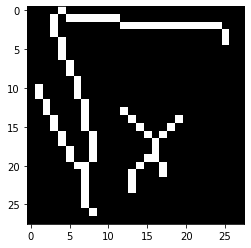

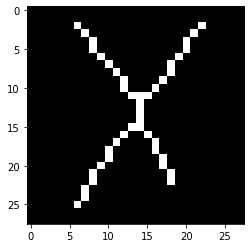

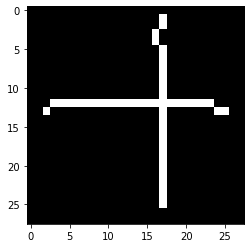

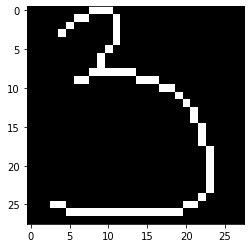

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


1 ((134, 173), (189, 271))
1 ((204, 194), (223, 264))
x ((231, 207), (276, 257))
) ((288, 182), (305, 274))
= ((325, 212), (370, 244))
sqrt ((391, 153), (506, 275))
x ((440, 211), (473, 258))
+ ((505, 206), (549, 250))
3 ((568, 174), (636, 259))
1
1
x
)
=
sqrt{x}
+
3
1
1
x
)
=
sqrt{x}
+
3
nodes end found f(x)=\sqrt{x}+3


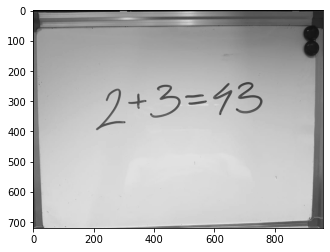

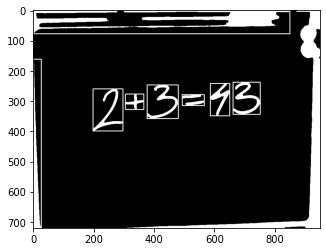

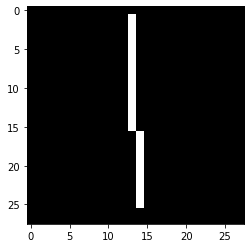

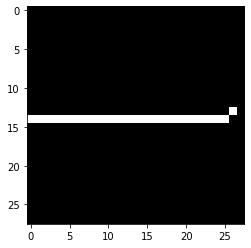

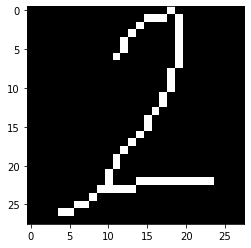

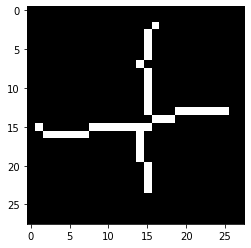

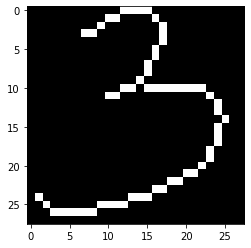

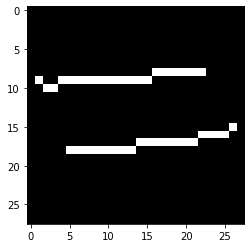

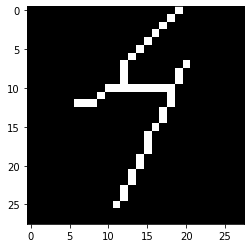

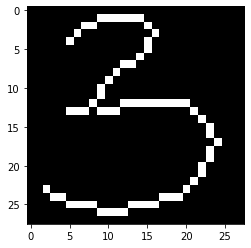

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


1 ((0, 162), (27, 720))
- ((0, 0), (849, 78))
2 ((198, 260), (297, 399))
+ ((305, 277), (366, 328))
3 ((377, 247), (480, 358))
= ((493, 279), (566, 315))
+ ((586, 242), (650, 349))
3 ((661, 238), (751, 344))
-_{12+3=+3}
-_{12+3=+3}
1
2
+
3
=
+
3
1
2
+
3
=
+
3
nodes end found -_{12+3=+3}


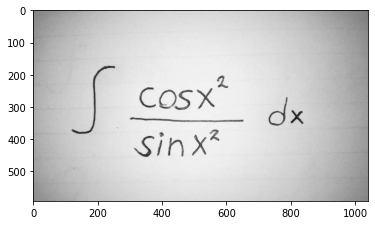

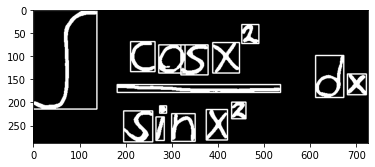

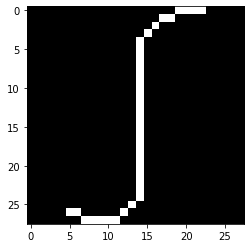

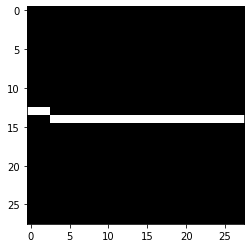

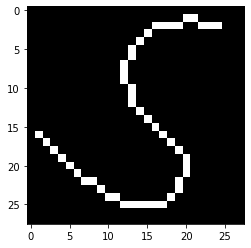

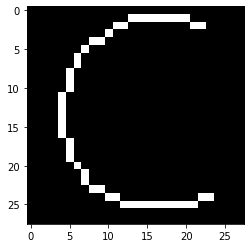

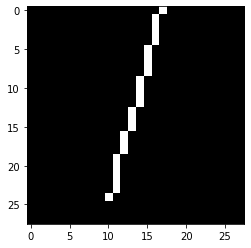

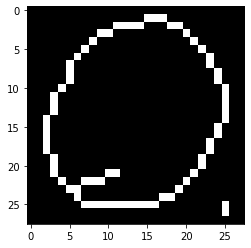

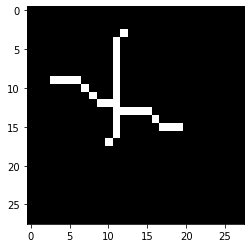

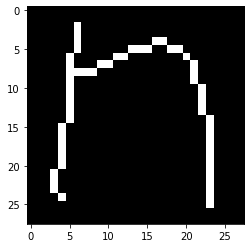

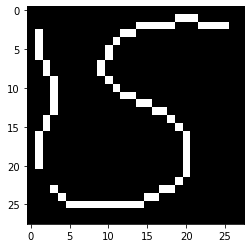

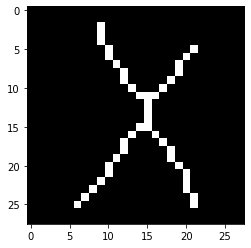

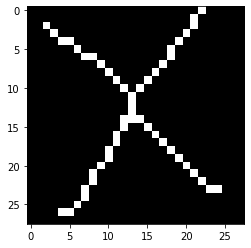

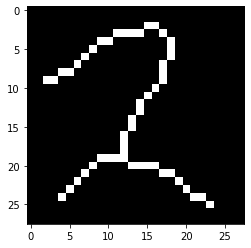

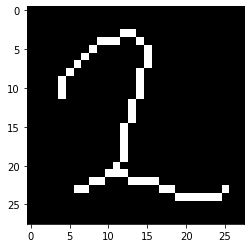

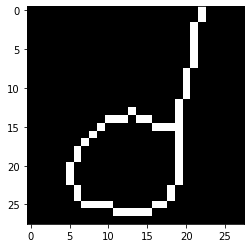

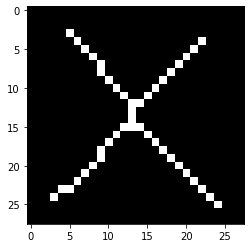

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 0), (138, 214))
- ((182, 161), (536, 178))
5 ((196, 218), (259, 285))
c ((211, 68), (264, 133))
1 ((266, 231), (284, 282))
0 ((272, 75), (329, 136))
+ ((274, 207), (289, 223))
n ((300, 224), (351, 284))
5 ((320, 75), (379, 140))
x ((375, 215), (421, 281))
x ((389, 70), (447, 136))
2 ((430, 199), (461, 235))
2 ((452, 31), (489, 72))
d ((612, 98), (673, 189))
x ((681, 138), (722, 183))
\int
\frac{c05x2}{51+nx2}
d
x
\int
\frac{c05x2}{51+nx2}
d
x
c
0
5
x^{2}
c
0
5
x^{2}
5
+_{1}
n
x^{2}
5
+_{1}
n
x^{2}
nodes end found  \int \frac{ \cos x^{2}}{5+_{1}nx^{2}} dx 


In [452]:
for img in all_imgs:
    conv_network_ref.predict(img)

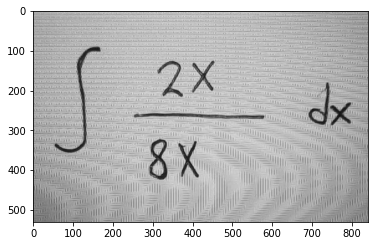

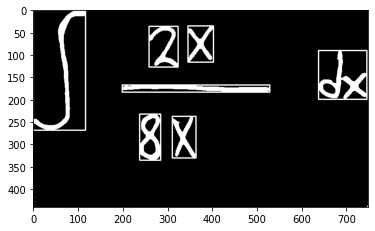

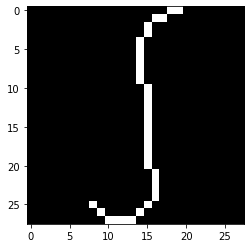

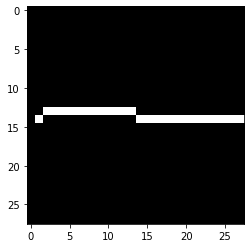

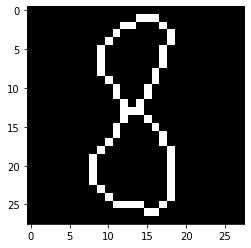

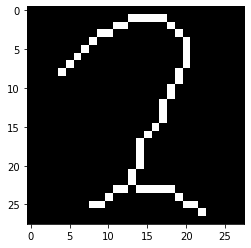

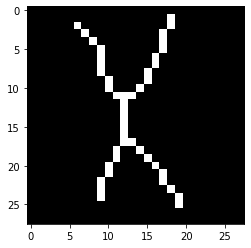

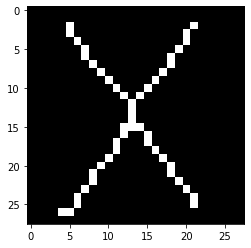

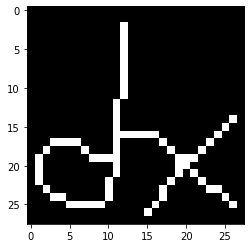

/Users/andrejpopordanoski/opt/miniconda3/envs/mer-env2/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-448-4d2b880bbfb0>:181: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif result == 'sqrt':


\int ((0, 0), (117, 268))
- ((199, 167), (529, 183))
8 ((238, 232), (285, 335))
2 ((259, 36), (324, 127))
x ((311, 237), (364, 330))
x ((346, 35), (403, 116))
2 ((638, 90), (746, 199))
\int
\frac{2x}{8x}
2
\int
\frac{2x}{8x}
2
2
x
2
x
8
x
8
x
nodes end found  \int \frac{2x}{8x}2


In [457]:
img = cv2.imread('./teski_sliki/slika-cista_2.png', cv2.IMREAD_GRAYSCALE)

conv_network_ref.predict(img)
# fft_filtering(img)

In [ ]:
from scipy import fftpack

def fft_filtering(im):
    plt.imshow(im, cmap='gray')
    plt.show()
    im_fft = fftpack.fft2(im)
    # Define the fraction of coefficients (in each direction) we keep
    keep_fraction = 0.1

    # Call ff a copy of the original transform. Numpy arrays have a copy
    # method for this purpose.
    im_fft2 = im_fft.copy()

    # Set r and c to be the number of rows and columns of the array.
    r, c = im_fft2.shape

    # Set to zero all rows with indices between r*keep_fraction and
    # r*(1-keep_fraction):
    im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

    # Similarly with the columns:
    im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

    plt.figure()
    plt.title('Filtered Spectrum')
    im_new = fftpack.ifft2(im_fft2).real

    plt.figure()
    plt.imshow(im_new, plt.cm.gray)
    plt.title('Reconstructed Image')
    return im_new


In [117]:
def checkForBracket(equation):
    equation =  equation.replace("1x)", "(x)").replace("(x1", "(x)")
    brackets = []
    for index, char in enumerate(equation):
        

        if(char == '('):
            brackets.append(index)
        if(char == ')'):
            if(len(brackets) > 0):
                brackets.pop()
            else:
                print("e da de")
                list1 = list(equation)
                list1[index] = '1'
                equation = ''.join(list1)

    if(len(brackets) > 0):
        for bracket in brackets:
            list1 = list(equation)
            list1[bracket] = '1'
            equation = ''.join(list1)


    return equation

In [122]:
equation = "((3456)"
equation = checkForBracket(equation)
print(equation)

len is 2
1(3456)


In [305]:
!pip3 install visualkeras

     |████████████████████████████████| 487 kB 100 kB/s eta 0:00:01
